## PyHHB: Haley edition

Here's my home base for all thigns PyHHB at the moment.

TABLE OF CONTENTS:
1. Import packages
2. Define `longitude_flip()` function
3. Define `SurvLivFull()` function & relevant constants
4. Recreating Figure 2 from Vanos et al (2023)
5. Running PyHHB with CMIP data
6. Plotting results from a single model
7. Multi-model averaging
8. Multi-model average difference plotting
9. What if we calculated a warming level
10. Bias correction
11. Random bullshit

# 1. Import packages

Import packages and set `rcParams`.

In [1]:
# =============================================================================
# Load packages
# ==============================================================================

import HHB as PyHHB
import SurvLivFull
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
from scipy.stats import mannwhitneyu
import datetime
from math import sqrt
from joblib import Parallel, delayed
from global_land_mask import globe
import pandas as pd
import glob
import pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

C:\Users\haley\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#-----HS: Here we change the default runtime configuration (rc) settings for 
#         matplotlib, i.e. how plots show up by default.

from matplotlib import rcParams
rcParams['legend.frameon']= False 
rcParams['legend.markerscale']=2.
rcParams['legend.fontsize']=14.
rcParams['axes.edgecolor']='0.8'
rcParams['axes.labelcolor']='0.15'
rcParams['axes.linewidth']='0.8'
rcParams['axes.labelsize']=14
rcParams['axes.titlesize']=19
rcParams[u'text.color']= u'.15'
rcParams[u'xtick.direction']= u'in'
rcParams[u'xtick.major.width']= 0.5
rcParams[u'xtick.labelsize']= 13
rcParams[u'ytick.labelsize']= 13
rcParams[u'ytick.color']=u'.15'
rcParams[u'ytick.direction']=u'in'
rcParams[ u'font.sans-serif']=[u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']

# 2. Define `longitude_flip()` function

In [3]:
def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.
        
        ** Only works for global data. Do not apply to data with a clipped longitude range **
        
        Parameters
        ----------
        var : Data Array
    """    
    # get var info
    x = var.lon # extract original longitude values
    lon_name = x.name        # store name of longitude coordinate
    nx = len(x)              # longitude resolution
    
    # determine longitude format and create an array of new lons in opposite convention
    if min(x) < 0: 
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons = np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x) > 180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons = np.linspace((min(x)-180), (max(x)-180), nx)
        
    # shift the data by 180° of longitude
    nshift = nx // 2
    var = var.roll({lon_name: nshift}, roll_coords = False)
            
    # update longitude coord with new values
    var = var.assign_coords({lon_name : new_lons})
    
    # add attributes documenting change
    # timestamp = datetime.now().strftime("%B %d, %Y, %r")
    # var.attrs['history'] = f'flipped longitudes {timestamp}'
    # var.attrs['original_lons'] = x.values
    
    return(var)

# 3. Define `SurvLivFull()` function & relevant constants

## 3.1. Defining constants
You might never want any of the following items to change across any hypothetical people or settings, so we can define these constants oustide of any loops. Some of these are immutable constants, facts of life; others could be tinkered with by the user to achieve representations of various diverse peoples and conditions, like resting metabolic rate. In previous PyHHB code, some of these items were defined in a "personal profile" that would be loaded in as a .txt file. Here, we ask the user to supply them in the Jupyter Notebook instead. Be sure to consider each choice carefully before using the SurvLivFull function.

In [7]:
# ----------------- Initial conditions; basal prerequisites -----------------

# ///////////////////////////////////

# Constants that seem pretty immutable to me:

# density
# Density of sweat, in kg / L
# Assumed to be equivalent to that of water. Maybe we can improve upon this assumption later, but it 
# probably wouldn't matter too much.
density = 1

# Lh_vap
# Heat of vaporisation of water at 30⁰C, 2426 J · g ^(-1)
Lh_vap = PyHHB.Lh_vap

# ///////////////////////////////////

# Things the user will want to define on a case-by-case basis:

# Hprod_rest
# Internal heat production at rest, in W / kg

Hprod_rest = 1.8

# ///////////////////////////////////

# Things that were originally defined in a "personal profile" (you can change them if you want, but 
# existing personal profiles may provide you with a good benchmark to start with):

# (I will be taking these example values from Young_adult_livability.txt)

# Tsk_C
# Skin temperature, in degrees C
Tsk_C = 35.0

# Emm_sk
# Area weighted emissivity of the clothed body surface, dimentionless
Emm_sk = 0.98

# M
# Metabolic rate
# We assume the metabolic rate of a person is 1.8 W / kg. Hprod_rest = M - W, and in usage of PyHHB so 
# far, we assume W = 0. As such, M = Hprod_rest most of the time.
# UPDATE 1/21/24: This is no longer a fixed number but rather dependent on Hprod_rest and Mass, as
# defined later in this cell.
# UPDATE 5/8/24: Actually, now defining M, W, Hprod_rest, and Mass happens in the SurvLivFull function!
# M = 1.8

# W
# External work being done, in W
# In usage of PyHHB thus far, we conservatively assume that the subject is not doing any external work, 
# and is at rest.
W = 0

# Av_ms
# Wind speed (m / s)
Av_ms = 2.68

# ///////////////////////////////////

# Things that are different between survivability and livability

# A_eff
# Effective radiative area of the body, dimentionless
A_eff_surv = 0.70
A_eff_liv = 0.73

# Icl
# Insulation clothing value, in CLO
Icl_surv = 0
Icl_liv = 0.36

# Re_cl
# Evaporative resistance of clothing
Re_cl_surv = 0
Re_cl_liv = 0.01

# ///////////////////////////////////

## 3.2. Define `SurvLivFull()`

The following cell defines the PyHHB model. The user inputs a temperature, humidity, and pressure, and is rewarded with the maximum metabolic rate that a person could achieve in those conditions -- the person in question being defined in the prior cell.

In [8]:
def SurvLivFull(Ta_C, hu, hu_type, PB_kPa = 101.3, sun = "Night-Indoors", old_or_young = 'young', 
                Exp_time = 3, Mmax_only = False):

# This function defines the Python Human Heat Balance Model (PyHHB). See Vanos et al (2023) for more
# information.

# PURPOSE: Given a temperature and humidity, output information about human survivability and livability
#          in those conditions.

# IMPORTANT NOTE: Please read about the following input choices CAREFULLY. Circumstances of heat
#                 exposure (age, exposure time, shade conditions) create large deviations in results.

# INPUT PARAMETERS:

# Ta_C: float or array, near-surface air temperature (C)
# hu: float or array, humidity in either specific humidity (dimensionless) or RH (dimensionless)
# hu_type: str, describes given humidity metric, 'q' or 'rh'. IMPORTANT NOTE: If using RH, your input 
#          should be between 0 and 1! Do NOT use a percentage!
# PB_kPa: barometric pressure in kPa; defaults to 101.3 kPa
# Av_ms: Wind speed (m / s); defaults to 1 m / s
# sun: str, describes sunlight conditions, 'Night-Indoors' or 'Day-Outdoors'; defaults to 
#      'Night-Indoors'.
# old_or_young: str, choose whether you wish to consider a healthy young adult (aged 18-45) or an old 
#               adult (65+), 'old' or 'young'. Defaults to 'young'.
# Exp_time: int, exposure time, in hours. Right now, PyHHB is only configured for exposure times of 3 or
#           6 hours. Don't use input other than 3 or 6. Choose whichever option is appropriate for the
#           model output you're applying PyHHB to (if model output is your usecase). Defaults to 3.

# Default conditions assume a most optimistic scenario.

# OUTPUT PARAMETERS:

# (will fill this in later if I have more time)

# --------------------------------------------------------------------------------------------#

#     print("Icl_surv:")
#     print(Icl_surv)
#     print(" ")
#     print("-----------")
#     print(" ")
    
#     print("Re_cl_surv:")
#     print(Re_cl_surv)
#     print(" ")
#     print("-----------")
#     print(" ")

# FIRST: Data preprocessing & defining of constants.
# Some constants will change based on parameters the user has defined. Let's define them now.
# Additionally, we will need to put temperature and humidity into NumPy arrays if they aren't already.

    if old_or_young == 'old':

        # person_condition
        # Maximum skin wettedness based on condition
        # The maximum skin wettedness of a person changes depending on heat acclimation status. Here are
        # some values from the PyHHB documentation:

        #     ISO:
        #     Unacclimated = 0.85
        #     Acclimatied = 1.00

        #     Ravanelli et al. MSSE (2018):
        #     Untrained & Unacclimated = 0.72
        #     Trained & Unacclimated = 0.84
        #     Trained & Acclimated = 0.95

        #     Morris 2015
        #     YNG Morris 2015 = 0.65
        #     OLD Morris 2015 = 0.5

        # The relevant PyHHB function, PyHHB.wmax(), recognizes the following strings as valid values of
        # person_condition:

        # 'Unacclimated'
        # 'fully acclimated'
        # 'Untrained & Unacclimated'
        # 'Trained & Unacclimated'
        # 'Trained & Acclimated'
        # 'YNG_Morris_2021'
        # 'OLD_Morris_2021'

        person_condition = "OLD_Morris_2021"

        # Mass, in kg
        Mass = 73.9

        # Height, in m
        # This can be set to -9999 to indicate you'd rather define a specific value for AD in the 
        # personal profile.
        Height = -9999

        # AD
        # Corporeal surface area, in m ^ 2; can either be given in a personal profile or estimated from
        # mass and height
        AD = 1.78
        # AD = PyHHB.AD_from_mass_height(Mass, Height)

        # Smax
        # Maximum sweat rate, in L · h ^ (-1).
        Smax = 0.51

    elif old_or_young == 'young':

        # person_condition
        # Maximum skin wettedness based on condition
        # The maximum skin wettedness of a person changes depending on heat acclimation status. Here are
        # some values from the PyHHB documentation:

        #     ISO:
        #     Unacclimated = 0.85
        #     Acclimatied = 1.00

        #     Ravanelli et al. MSSE (2018):
        #     Untrained & Unacclimated = 0.72
        #     Trained & Unacclimated = 0.84
        #     Trained & Acclimated = 0.95

        #     Morris 2015
        #     YNG Morris 2015 = 0.65
        #     OLD Morris 2015 = 0.5

        # The relevant PyHHB function, PyHHB.wmax(), recognizes the following strings as valid values of
        # person_condition:

        # 'Unacclimated'
        # 'fully acclimated'
        # 'Untrained & Unacclimated'
        # 'Trained & Unacclimated'
        # 'Trained & Acclimated'
        # 'YNG_Morris_2021'
        # 'OLD_Morris_2021'

        person_condition = "YNG_Morris_2021"

        # Mass, in kg
        Mass = 56.2

        # Height, in m
        # This can be set to -9999 to indicate you'd rather define a specific value for AD in the 
        # following line.
        Height = -9999

        # AD
        # Corporeal surface area, in m ^ 2; can either be given manually below or estimated from
        # mass and height using a PyHHB function
        AD = 1.6
        # AD = PyHHB.AD_from_mass_height(Mass, Height)

        # Smax
        # Maximum sweat rate, in L · h ^ (-1).
        Smax = 0.75
        
    # Now that we know all that, we can calculate a couple more constants.
    
    # print("AD:")
    # print(AD)
    # print(" ")
    # print("-----------")
    # print(" ")
    
    # ///////////////////////////////////

# UPDATE 1/21/24: This has become a fixed value moved defined earlier in this notebook
# Hprod_rest
# Internal heat production at rest, in W / kg

# Hprod_rest = M - W

# M
# Metabolic rate
# We assume the metabolic rate of a person is 1.8 W / kg. Hprod_rest = M - W, and in usage of PyHHB so 
# far, we assume W = 0. As such, M = Hprod_rest most of the time.
# UPDATE 1/21/24: This is used to be a fixed number defined earlier in the cell, but now it's dependent
# on Hprod_rest and Mass.
    M = Hprod_rest * Mass

# M_rest
# Resting metabolic rate; metabolic energetic expenditure while people are resting, in W.
    M_rest = Hprod_rest * Mass
    
# Now, see if we need to change the type of Ta_C and hu.

    if type(Ta_C) == int or type(Ta_C) == float or type(Ta_C) == list:
        Ta_C = np.array([Ta_C])
        
    if type(hu) == int or type(hu) == float or type(hu) == list:
        hu = np.array([hu])
        
# If we were given specific humidity, it will need to be converted to RH. Before we do that, though, we
# need to calculate the mixing ratio.
# UPDATE 1/21/24: Mixing ratio is a new necessary component of the model

    if hu_type == 'q':
        
        # mixing_ratio
        mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(hu)
        
        RH = mpcalc.relative_humidity_from_specific_humidity(PB_kPa * units.kPa, Ta_C * units.degC, 
                                                             hu)
        
    elif hu_type == 'rh':
        
        # mixing ratio
        mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(PB_kPa * units.kPa, Ta_C * units.degC,
                                                                  hu)
        
        # print("mixing_ratio: " + str(mixing_ratio))
        
        RH = hu

# ///////////////////////////////////

# Things that need to be calculated/require knowledge of prior constants and choices and WILL change as
# a result of climatic variables, but require no extra input than what we've given already:

# mrt_C
# Mean radiant temperature, in C
# mrt_C is Ta_C if indoors and Ta_C + 15 if outdoors. 

    if sun == "Night-Indoors":
        mrt_C = Ta_C
    elif sun == "Day-Outdoors":
        mrt_C = Ta_C + 15
        
# SECOND: Run the model.

# The following code is separated into "tiers." All the information from a higher tier is necessary
# to calculate values in a lower tier.
        
# ----------------- Tier 9 -----------------

# UPDATE 1/21/24: This tier is wholly unnecessary, but we have to put it right here as a sanity check.

    # print("Tier 9 features:")
    # print("mrt_C: " + str(mrt_C))
    # print("Tsk_C: " + str(Tsk_C))
    # print("Emm_sk: " + str(Emm_sk))
    # print("A_eff_surv: " + str(A_eff_surv))
    # print("A_eff_liv: " + str(A_eff_liv))
    # print("Av_ms: " + str(Av_ms))
    # print("Ta_C: " + str(Ta_C))

        
# ----------------- Tier 8 -----------------

    # hr_cof_from_radiant_features
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    hr_cof_from_radiant_features_surv = PyHHB.hr_cof_from_radiant_features(mrt_C, Tsk_C, Emm_sk, 
                                                                           A_eff_surv)
    hr_cof_from_radiant_features_liv = PyHHB.hr_cof_from_radiant_features(mrt_C, Tsk_C, Emm_sk, 
                                                                          A_eff_liv)
    
    # hc_cof_from_Av
    hc_cof_from_Av = PyHHB.hc_cof_from_Av(Av_ms)
    
    # Psa_kPa_from_TaC
    Psa_kPa_from_TaC = PyHHB.Psa_kPa_from_TaC(Tsk_C)
    
    # print("Psa_kPa_from_TaC:")
    # print(Psa_kPa_from_TaC)
    # print(" ")
    # print("-----------")
    # print(" ")
    
    # print("Tier 8 features:")
    # print("hr_cof_from_radiant_features_surv: " + str(hr_cof_from_radiant_features_surv))
    # print("hr_cof_from_radiant_features_liv: " + str(hr_cof_from_radiant_features_liv))
    # print("hc_cof_from_Av: " + str(hc_cof_from_Av))
    # print("Psa_kPa_from_TaC: " + str(Psa_kPa_from_TaC))

    
# ----------------- Tier 7 -----------------

    # to_from_hr_tr_hc_ta
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    to_from_hr_tr_hc_ta_surv = PyHHB.to_from_hr_tr_hc_ta(hr_cof_from_radiant_features_surv, mrt_C, 
                                                         hc_cof_from_Av, Ta_C)
    to_from_hr_tr_hc_ta_liv = PyHHB.to_from_hr_tr_hc_ta(hr_cof_from_radiant_features_liv, mrt_C, 
                                                        hc_cof_from_Av, Ta_C)
        
    # h_coef_from_hc_hr
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    h_coef_from_hc_hr_surv = PyHHB.h_coef_from_hc_hr(hc_cof_from_Av, hr_cof_from_radiant_features_surv)
    h_coef_from_hc_hr_liv = PyHHB.h_coef_from_hc_hr(hc_cof_from_Av, hr_cof_from_radiant_features_liv)
    
    # vapor_pressure
    # UPDATE 1/21/24: Now metpy function rather than PyHHB function
    # Pv_kPa_from_Psa_RH = PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa_from_TaC, RH)
    vapor_pressure = mpcalc.vapor_pressure(PB_kPa * units.kPa, mixing_ratio).magnitude
    
    # print("vapor_pressure:")
    # print(vapor_pressure)
    # print(" ")
    # print("-----------")
    # print(" ")
    
    # print("Tier 7 features:")
    # print("to_from_hr_tr_hc_ta_surv: " + str(to_from_hr_tr_hc_ta_surv))
    # print("to_from_hr_tr_hc_ta_liv: " + str(to_from_hr_tr_hc_ta_liv))
    # print("h_coef_from_hc_hr_surv: " + str(h_coef_from_hc_hr_surv))
    # print("h_coef_from_hc_hr_liv: " + str(h_coef_from_hc_hr_liv))
    # print("vapor_pressure: " + str(vapor_pressure))
    
# ----------------- Tier 6 -----------------

    # Dry_Heat_Loss_c_plus_r
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Dry_Heat_Loss_c_plus_r_surv = PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C, to_from_hr_tr_hc_ta_surv, 
                                                               Icl_surv, h_coef_from_hc_hr_surv, AD)
    Dry_Heat_Loss_c_plus_r_liv = PyHHB.Dry_Heat_Loss_c_plus_r(Tsk_C, to_from_hr_tr_hc_ta_liv, Icl_liv,
                                                              h_coef_from_hc_hr_liv, AD)

    # Cres_from_M_Ta
    Cres_from_M_Ta = PyHHB.Cres_from_M_Ta(M, Ta_C, AD)

    # Eres_from_M_Pa
    # UPDATE 1/21/24: Now takes vapor_pressure rather than Pv_kPa_from_Psa_RH
    Eres_from_M_Pa = PyHHB.Eres_from_M_Pa(M, vapor_pressure, AD)
    
    # he_cof
    he_cof = PyHHB.he_cof(hc_cof_from_Av)
    
    # print("he_cof:")
    # print(he_cof)
    # print(" ")
    # print("-----------")
    # print(" ")
    
    # print("Tier 6 features:")
    # print("Cres_from_M_Ta: " + str(Cres_from_M_Ta))
    # print("Eres_from_M_Pa: " + str(Eres_from_M_Pa))
    # print("Dry_Heat_Loss_c_plus_r_surv: " + str(Dry_Heat_Loss_c_plus_r_surv))
    # print("Hprod_survive: " + str(M_rest))
    # print("Dry_Heat_Loss_c_plus_r_liv: " + str(Dry_Heat_Loss_c_plus_r_liv))
    # print("he_cof: " + str(he_cof))
    
# ----------------- Tier 5 -----------------

    # Ereq_from_HeatFluxes
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Ereq_from_HeatFluxes_surv = PyHHB.Ereq_from_HeatFluxes(M, W, Dry_Heat_Loss_c_plus_r_surv, 
                                                           Cres_from_M_Ta, Eres_from_M_Pa)
    Ereq_from_HeatFluxes_liv = PyHHB.Ereq_from_HeatFluxes(M, W, Dry_Heat_Loss_c_plus_r_liv, 
                                                          Cres_from_M_Ta, Eres_from_M_Pa)
    # Emax_env
    # UPDATE 1/21/24: Now takes vapor_pressure instead of Pv_kPa_from_Psa_RH
    #                 Needs two branches for survivability and livability
    Emax_env_surv = PyHHB.Emax_env(Psa_kPa_from_TaC, vapor_pressure, Re_cl_surv, he_cof, Icl_surv, AD)
    Emax_env_liv = PyHHB.Emax_env(Psa_kPa_from_TaC, vapor_pressure, Re_cl_liv, he_cof, Icl_liv, AD)
    
    Emax_env_surv[Emax_env_surv<0] = 0
    Emax_env_liv[Emax_env_liv<0] = 0
    
    # print("Ereq:")
    # print(Ereq_from_HeatFluxes_surv)
    # print(" ")
    # print("-----------")
    # print(" ")
    # print("Emax_env:")
    # print(Emax_env_surv)
    # print(" ")
    # print("-----------")
    # print(" ")
    # print("Tier 5 features:")
    # print("Ereq_from_HeatFluxes_surv: " + str(Ereq_from_HeatFluxes_surv))
    # print("Ereq_from_HeatFluxes_liv: " + str(Ereq_from_HeatFluxes_liv))
    # print("Emax_env_surv: " + str(Emax_env_surv))
    # print("Emax_env_liv: " + str(Emax_env_liv))
    
# ----------------- Tier 4 -----------------
    # wreq_HSI_skin_wettedness
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    wreq_HSI_skin_wettedness_surv = PyHHB.wreq_HSI_skin_wettedness(Ereq_from_HeatFluxes_surv, 
                                                                   Emax_env_surv)
    # print("Wreq:")
    # print(wreq_HSI_skin_wettedness_surv)
    # print(" ")
    # print("-----------")
    # print(" ")
    wreq_HSI_skin_wettedness_liv = PyHHB.wreq_HSI_skin_wettedness(Ereq_from_HeatFluxes_liv, 
                                                                  Emax_env_liv)
    
    # print("Tier 4 features:")
    # print("wreq_HSI_skin_wettedness_surv: " + str(wreq_HSI_skin_wettedness_surv))
    # print("wreq_HSI_skin_wettedness_liv: " + str(wreq_HSI_skin_wettedness_liv))
    
# ----------------- Tier 3 -----------------

    # wmax
    wmax = PyHHB.wmax(person_condition)
    
    # 4. Sweating_efficiency_r
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Sweating_efficiency_r_surv = PyHHB.Sweating_efficiency_r(wreq_HSI_skin_wettedness_surv)
    Sweating_efficiency_r_liv = PyHHB.Sweating_efficiency_r(wreq_HSI_skin_wettedness_liv)
    
    # print("Tier 3 features:")
    # print("wmax: " + str(wmax))
    # print("Sweating_efficiency_r_surv: " + str(Sweating_efficiency_r_surv))
    # print("Sweating_efficiency_r_liv: " + str(Sweating_efficiency_r_liv))
    
# ----------------- Tier 2 -----------------

    # Emax_wettedness
    # UPDATE 1/21/24: Now takes vapor_pressure instead of Pv_kPa_from_Psa_RH
    #                 Needs two branches for survivability and livability
    # Emax_wettedness = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl, he_cof,
    #                                         Icl, AD)
    Emax_wettedness_surv = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl_surv, 
                                                 he_cof, Icl_surv, AD)
    Emax_wettedness_liv = PyHHB.Emax_wettedness(wmax, Psa_kPa_from_TaC, vapor_pressure, Re_cl_liv, 
                                                he_cof, Icl_liv, AD)

    # Emax_sweat_rate
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    Emax_sweat_rate_surv = PyHHB.Emax_sweat_rate(Smax, Lh_vap, density, Sweating_efficiency_r_surv)
    Emax_sweat_rate_liv = PyHHB.Emax_sweat_rate(Smax, Lh_vap, density, Sweating_efficiency_r_liv)

    # Sreq
    # UPDATE 1/21/24: Needs two branches for survivability and livability
    # print("Sreq_surv:")
    Sreq_surv = PyHHB.Sreq(Ereq_from_HeatFluxes_surv, Sweating_efficiency_r_surv, Lh_vap)
    # print(" ")
    # print("----------")
    # print(" ")
    # print("Sreq_liv:")
    Sreq_liv = PyHHB.Sreq(Ereq_from_HeatFluxes_liv, Sweating_efficiency_r_liv, Lh_vap)
    # print(" ")
    # print("----------")
    # print(" ")    
    # print("Tier 2 features:")
    # print("Emax_wettedness_surv: " + str(Emax_wettedness_surv))
    # print("Emax_wettedness_liv: " + str(Emax_wettedness_surv))
    # print("Emax_sweat_rate_surv: " + str(Emax_sweat_rate_surv))
    # print("Emax_sweat_rate_liv: " + str(Emax_sweat_rate_liv))
    # print("Sreq_surv: " + str(Sreq_surv))
    # print("Sreq_liv: " + str(Sreq_liv))
    
# ----------------- Tier 1 -----------------

    # survivability
    survivability, flag_survivability = PyHHB.Survivability(Exp_time, Ereq_from_HeatFluxes_surv, 
                                                            Emax_wettedness_surv, Emax_sweat_rate_surv,
                                                            Sreq_surv, Smax, Mass)
    
    # print("Tier 1 features:")
    # print("survivability: " + str(survivability))
    # print("flag_survivability: " + str(flag_survivability))
    
# ----------------- Tier 0 -----------------
# ----------------- ULTIMATE GOAL: OBTAIN LIVABILITY -----------------

    Mmax, mask_non_livable = PyHHB.livability_Mmax(survivability, Ereq_from_HeatFluxes_liv, 
                                                   Emax_wettedness_liv, Emax_sweat_rate_liv, M_rest)
    
    # Extra: Convert Mmax from W to METs

    Mmax = PyHHB.MetabolicRate_W_to_MET_Mass(Mmax, Mass)
    
    # print("Tier 0 features:")
    # print("Mmax: " + str(Mmax))
    # print("mask_non_livable: " + str(mask_non_livable))
    
    if Mmax_only == True:
        
        return Mmax
    
    else:
    
        return survivability, flag_survivability, Mmax, mask_non_livable

Let's do a test run of this function on some random conditions, just to make sure it works.

In [14]:
survivability, flag_survivability, Mmax, mask_non_livable = SurvLivFull(33.89, .4, 'rh', PB_kPa = 101.0, old_or_young = 'young', sun = 'Day-Outdoors')
# Mmax = SurvLivFull(30, .5, 'rh', Mmax_only = True)
# print("Smax: " + str(Smax))
print(" ")
print("-----------")
print(" ")
print("Survivable?")
print(survivability)
print("Survivability flag:")
print(flag_survivability)
print("Mmax:")
print(Mmax)
print("Survivable but not livable?")
print(mask_non_livable)

 
-----------
 
Survivable?
[ True]
Survivability flag:
[1.]
Mmax:
[4.50852736]
Survivable but not livable?
[False]


# 4. Recreating Figure 2 from Vanos et al (2023)

In [7]:
# =============================================================================
# Defining directories
# =============================================================================

# workdir = 'D:/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model/'
# workdir = 'C:/Users/gguzma20/Dropbox (ASU)/Gisel PhD/Survivability Paper Development/Model/'
workdir = 'C:/Users/Haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/latest_PyHHB/'

path_profiles  = workdir + 'personal_profiles/'

#-----HS: make a list of all the filepath names in the personal_profiles folder
list_profiles = glob.glob(path_profiles + '*.txt')

path_save_matrix = workdir + 'outputs/gisel/01_Survivability_results/Survivability_matrix/'
path_save_lines = workdir + 'outputs/gisel/01_Survivability_results/Survivability_lines_thresholds/'
path_save_figures  = workdir + 'outputs/gisel/01_Survivability_results/'

In [8]:
temperature = np.arange(25,60,0.1)

# Dealing with different types of humidity (input model is Ambient vapour pressure in kPa)
#-----HS: Regardless of whcat kind of humidity metric you're using, the goal here is to
#         estimate the ambient water vapor pressure given some value of temperature and 
#         humidity; we're putting all possible combinations in a table.

version = 'rh'

if version == 'rh':
    #-----HS: Pick a range of humidity values we care about for this metric
    humidity =  np.arange(0.005,1.005,0.005)
    hum_label = 'Relative humidity (%)'
    xx_temp, yy_humidity = np.meshgrid(temperature, humidity)
    #-----HS: This function estimates saturated vapour pressure in kPa using ambient temperature, which
    #         we need for the next function
    Psa_kPa = 	PyHHB.Psa_kPa_from_TaC(xx_temp)#	kPa			Saturated vapour pressure in kPa
    #-----HS: This function estimates water vapour pressure of air mixed with water vapor, using 
    #         saturated vapor pressure and relative humidity
    # Pv  =   PyHHB.Pv_kPa_from_Psa_RH(Psa_kPa, yy_humidity) #kPa	    Ambient vapour pressure in kPa
    PB_kPa = 101.3
    mixing_ratio = mpcalc.mixing_ratio_from_relative_humidity(PB_kPa * units.kPa, xx_temp * units.degC, 
                                                              yy_humidity)
    # print(mixing_ratio)
    Pv = mpcalc.vapor_pressure(PB_kPa * units.kPa, mixing_ratio).magnitude

C:\Users\haley\OneDrive\Graduate\Research\epi_physo\PyHHB\PyHHB\latest_PyHHB\codes\HHB.py:688: RuntimeWarning: divide by zero encountered in divide
  wreq = Ereq/Emax_env
C:\Users\haley\AppData\Local\Temp\ipykernel_13284\1033189963.py:53: UserWarning: The following kwargs were not used by contour: 'lw'
  cb = plt.contour(xx,yy,survivability,colors = 'Black',lw=0.1)
C:\Users\haley\OneDrive\Graduate\Research\epi_physo\PyHHB\PyHHB\latest_PyHHB\codes\HHB.py:688: RuntimeWarning: divide by zero encountered in divide
  wreq = Ereq/Emax_env
C:\Users\haley\AppData\Local\Temp\ipykernel_13284\1033189963.py:53: UserWarning: The following kwargs were not used by contour: 'lw'
  cb = plt.contour(xx,yy,survivability,colors = 'Black',lw=0.1)
C:\Users\haley\OneDrive\Graduate\Research\epi_physo\PyHHB\PyHHB\latest_PyHHB\codes\HHB.py:688: RuntimeWarning: divide by zero encountered in divide
  wreq = Ereq/Emax_env
C:\Users\haley\AppData\Local\Temp\ipykernel_13284\1033189963.py:53: UserWarning: The followin

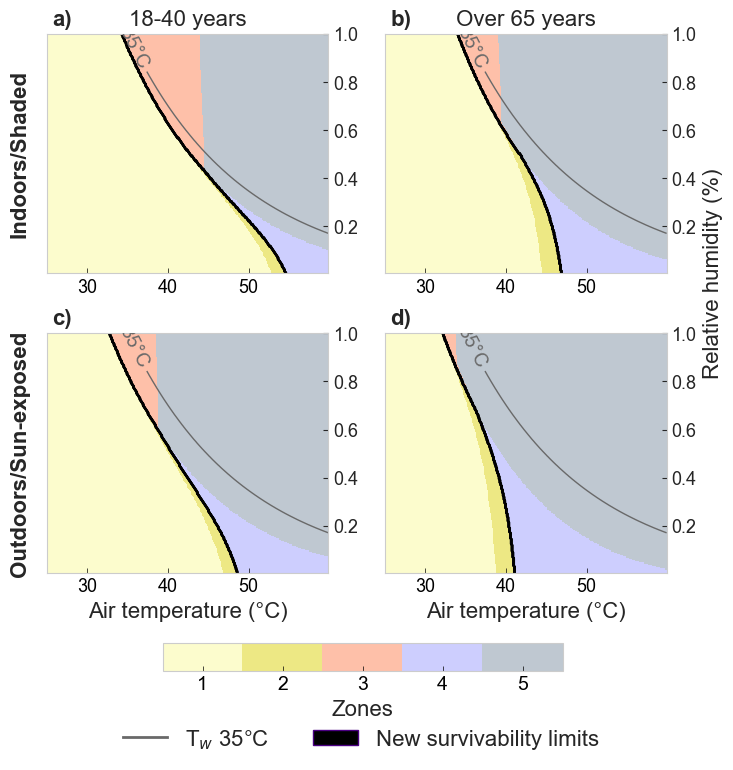

In [9]:
# =============================================================================
# Graphic Survivability types for 6H and different radiation conditions
# =============================================================================
# FIGURE 2, S1, S2
WBT_matrix = pd.read_csv(workdir+'outputs/gisel/00_WBT_matrix/'+version+'_version_WBT_matrix.csv', 
                         header = 0, 
                         index_col =0)
#This is to mask values with RH>100 in the graphs.
RH_matrix = pd.read_csv(workdir+'outputs/gisel/00_WBT_matrix/'+version+'_version_rh_matrix.csv', 
                        header = 0, 
                        index_col =0)
#This is to mask values of Vp>6 kPa
VpRH_matrix = pd.read_csv(workdir+'outputs/gisel/00_WBT_matrix/VP_in_rh_version_matrix.csv', 
                          header = 0, 
                          index_col =0)

cmap_survivability, bins_survivability, norm_survivability, tks_surv = PyHHB.Survivability_cmap()
ticks_survivability = tks_surv

xx = xx_temp
yy = yy_humidity
plt.close('all')
fig = plt.figure(figsize=(8,7))
gs=gridspec.GridSpec(2,2,hspace=0.25,wspace=0.2) #dos filas, 3 columnas: 

order = ['a)','b)','c)','d)']    
ii = 0


for sun in ['Night-Indoors','Day-Outdoors']:
    for name_profile in ['Young_adult','65_over']:
        
        if name_profile == 'Young_adult':
            old_or_young = 'young'
        elif name_profile == '65_over':
            old_or_young = 'old'
        
        survivability, flag_survivability, Mmax, mnl = SurvLivFull(xx_temp, yy_humidity, 'rh', 
                                                                   sun = sun, 
                                                                   old_or_young = old_or_young, 
                                                                   Exp_time = 6)
        
        mask_non_livable = mnl
        
        profile = PyHHB.read_personal_profiles(path_profiles + name_profile+'_survivability.txt')
    
        ax=plt.subplot(gs[ii])   
        
        #text number
        plt.text(0.02,1.06,order[ii],transform=ax.transAxes,verticalalignment='center',fontsize = 16,
                 weight='bold')
        #Setting survibability line
        cb = plt.contour(xx,yy,survivability,colors = 'Black',lw=0.1)
        cs = plt.pcolormesh(xx,yy,flag_survivability,cmap = cmap_survivability,
                            vmin=0.5, vmax=5.5, norm = norm_survivability)
        
        #Setting wbt
        cp = plt.contour(xx,yy,WBT_matrix,colors = 'Dimgrey', levels= [35],linewidths=(1,))
        # contour line labels
        plt.clabel(cp, fmt = 'T$_w$ %2.1d°C', colors = 'Dimgrey', manual= [(55,70)],fontsize=14)
        ax.yaxis.tick_right()   

        # #mask for values above 100%RH and VP>6kPa in rh matrix
        # if version != 'rh':
        #     plt.contourf(xx,yy,RH_matrix[RH_matrix>100],cmap = 'seismic',
        #                  levels =[100,np.nanmax(RH_matrix)],
        #                  zorder =2)
        # else:
        #     plt.contourf(xx,yy,WBT_matrix[WBT_matrix>37],cmap = 'seismic',
        #                  levels =[6,np.nanmax(WBT_matrix)],
        #                  zorder =2)
        #     #This line is just to cover the values that are nan in WBT matrix    
        #     plt.contourf(xx,yy,VpRH_matrix[VpRH_matrix>10],cmap = 'seismic',
        #                  levels =[6,np.nanmax(VpRH_matrix)],
        #                  zorder =2)
                
        if sun == 'Night-Indoors':
            plt.title(profile['name'], fontsize = 16)
            
        if sun == 'Day-Outdoors':
            plt.xlabel('Air temperature (°C)', fontsize = 16)

        if ii in [1]:
            plt.text(1.13,0,hum_label,transform=ax.transAxes,verticalalignment='center',rotation = 90,
                     fontsize = 16)

            
        if ii ==0:
            #Setting Ylabels
            plt.text(-0.13,0.5,'Indoors/Shaded',transform=ax.transAxes,verticalalignment='center',
                     rotation = 90,
                     fontsize = 16,weight='bold')
            plt.text(-0.13,-0.75,'Outdoors/Sun-exposed',transform=ax.transAxes,
                     verticalalignment='center',
                     rotation = 90,fontsize = 16,weight ='bold') 
        

        
        ii = ii + 1


#Setting colorbar
cax = fig.add_axes([0.27, -0.03, 0.5, 0.04])
cbar = plt.colorbar(cs, cax=cax,pad=0.08,fraction=0.04,ticks=[ticks_survivability],
                    orientation = 'horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(ticks_survivability) 
cbar.set_label('Zones',fontsize = 16)
        
#Setting legend
legend_elements = [Line2D([0], [0], color='DimGrey', lw=2, label='T$_w$ 35°C'),
                    Patch(facecolor='Black', edgecolor='Indigo', label='New survivability limits')]
plt.legend(handles=legend_elements,bbox_to_anchor=(1.14,-1.3),fontsize =16,ncol =2)


# plt.savefig(path_save_figures+version+'_Survivability_Flags_6H.jpeg',dpi=600,transparent=False,
#             bbox_inches='tight')   
plt.show();plt.close()
            

# 5. Running PyHHB with CMIP data

We'll need to load in and masssage our CMIP data a wee bit to ensure it plays nicely with the function we've defined above.

## 5.1. Define directories

First, let's define some traits about our working directory paths and model traits.

In [7]:
# =============================================================================
# Defining directories
# =============================================================================
workdir = 'C:/Users/haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'

path_data = workdir + 'CMIP_data/'
# path_data ='F:/CMIP_data/'
path_save = workdir + 'latest_PyHHB/outputs/Figures/'

## 5.2. Define model-specific dictionaries

Model traits are stored in a dictionary, so we need only define what model we have data from and the rest of the traits will be defined accordingly. Note that exposure time is defined in the above cell -- really, it would rather be defined by the dictionary. Also note that the GFDL data is a little strange here, as its naming conventions aren't quite the same -- I'll go back and fix that when I have more time.

In [8]:
models = {}

models['ACCESS-CM2'] = {'org' : 'CSIRO-ARCCSS', 
                        'model' : 'ACCESS-CM2', 
                        'ssp' : '245', 
                        'ripf' : 'r1i1p1f1', 
                        'grid' : 'gn', 
                        'ta_name' : 'tas', 
                        'hus_name' : 'huss', 
                        'ta_freq' : '3hr', 
                        'hus_freq' : '3hr', 
                        'ps_freq' : '3hr',
                        'hus_present_start' : '201601010300',
                        'hus_present_end' : '202512312100',
                        'hus_future_start' : '209101010000',
                        'hus_future_end' : '210012312100',
                        'ta_present_start' : '201601010300',
                        'ta_present_end' : '202512312100',
                        'ta_future_start' : '209101010000',
                        'ta_future_end' : '210012312100',
                        'ps_present_start' : '201601010300',
                        'ps_present_end' : '202512312100',
                        'ps_future_start' : '209101010000',
                        'ps_future_end' : '210012312100'}

models['BCC-CSM2-MR'] = {'org' : 'BCC', 
                         'model' : 'BCC-CSM2-MR', 
                         'ssp' : '245', 
                         'ripf' : 'r1i1p1f1', 
                         'grid' : 'gn', 
                         'ta_name' : 'tas', 
                         'hus_name' : 'huss', 
                         'ta_freq' : '3hr', 
                         'hus_freq' : '3hr', 
                         'ps_freq' : '3hr',
                         'hus_present_start' : '201601010000',
                         'hus_present_end' : '202512312100',
                         'hus_future_start' : '209101010000',
                         'hus_future_end' : '210012312100',
                         'ta_present_start' : '201601010000',
                         'ta_present_end' : '202512312100',
                         'ta_future_start' : '209101010000',
                         'ta_future_end' : '210012312100',
                         'ps_present_start' : '201601010000',
                         'ps_present_end' : '202512312100',
                         'ps_future_start' : '209101010000',
                         'ps_future_end' : '210012312100'}

models['CESM2'] = {'org' : 'NCAR', 
                   'model' : 'CESM2', 
                   'ssp' : '245', 
                   'ripf' : 'r11i1p1f1', 
                   'grid' : 'gn', 
                   'ta_name' : 'ta', 
                   'hus_name' : 'hus', 
                   'ta_freq' : '6hrLev', 
                   'hus_freq' : '6hrLev', 
                   'ps_freq' : '6hrLev',
                   'hus_present_start' : '201501010000',
                   'hus_present_end' : '202512311800',
                   'hus_future_start' : '208501010000',
                   'hus_future_end' : '209412312100',
                   'ta_present_start' : '201501010000',
                   'ta_present_end' : '202512311800',
                   'ta_future_start' : '208501010000',
                   'ta_future_end' : '209412312100',
                   'ps_present_start' : '201501010000',
                   'ps_present_end' : '202512311800',
                   'ps_future_start' : '208501010000',
                   'ps_future_end' : '209412312100'}

models['CMCC-ESM2'] = {'org' : 'CSIRO-ARCCSS', 
                        'model' : 'CMCC', 
                        'ssp' : '245', 
                        'ripf' : 'r1i1p1f1', 
                        'grid' : 'gn', 
                        'ta_name' : 'tas', 
                        'hus_name' : 'huss', 
                        'ta_freq' : '3hr', 
                        'hus_freq' : '3hr', 
                        'ps_freq' : '3hr',
                        'hus_present_start' : '201601010000',
                        'hus_present_end' : '202512312100',
                        'hus_future_start' : '209101010000',
                        'hus_future_end' : '210012312100',
                        'ta_present_start' : '201601010000',
                        'ta_present_end' : '202512312100',
                        'ta_future_start' : '209101010000',
                        'ta_future_end' : '210012312100',
                        'ps_present_start' : '201601010000',
                        'ps_present_end' : '202512312100',
                        'ps_future_start' : '209101010000',
                        'ps_future_end' : '210012312100'}

models['EC-Earth3'] = {'org' : 'EC-Earth-Consortium', 
                       'model' : 'EC-Earth3', 
                       'ssp' : '245', 
                       'ripf' : 'r1i1p1f1', 
                       'grid' : 'gn', 
                       'ta_name' : 'tas', 
                       'hus_name' : 'huss', 
                       'ta_freq' : '3hr', 
                       'hus_freq' : '3hr', 
                       'ps_freq' : '3hr',
                       'hus_present_start' : '201601010000',
                       'hus_present_end' : '202512312100',
                       'hus_future_start' : '209101010000',
                       'hus_future_end' : '210012312100',
                       'ta_present_start' : '201601010000',
                       'ta_present_end' : '202512312100',
                       'ta_future_start' : '209101010000',
                       'ta_future_end' : '210012312100',
                       'ps_present_start' : '201601010000',
                       'ps_present_end' : '202512312100',
                       'ps_future_start' : '209101010000',
                       'ps_future_end' : '210012312100'}

models['GFDL-ESM4'] = {'org' : 'GFDL', 
                       'model' : 'GFDL-ESM4', 
                       'ssp' : '245', 
                       'ripf' : 'r1i1p1f1', 
                       'grid' : 'gn', 
                       'ta_name' : 'tas', 
                       'hus_name' : 'huss', 
                       'ta_freq' : '3hr', 
                       'hus_freq' : '3hr', 
                       'ps_freq' : '3h',
                       'hus_present_start' : '201601010000',
                       'hus_present_end' : '202512312100',
                       'hus_future_start' : '209101010000',
                       'hus_future_end' : '210012312100',
                       'ta_present_start' : '201601010000',
                       'ta_present_end' : '202512312100',
                       'ta_future_start' : '209101010000',
                       'ta_future_end' : '210012312100',
                       'ps_present_start' : '201601010000',
                       'ps_present_end' : '202512312100',
                       'ps_future_start' : '209101010000',
                       'ps_future_end' : '210012312100'}

models['MIROC6'] = {'org' : 'MIROC', 
                    'model' : 'MIROC6', 
                    'ssp' : '245', 
                    'ripf' : 'r1i1p1f1', 
                    'grid' : 'gn', 
                    'ta_name' : 'tas', 
                    'hus_name' : 'huss', 
                    'ta_freq' : '3hr', 
                    'hus_freq' : '3hr', 
                    'ps_freq' : '3hr',
                    'hus_present_start' : '201601010000',
                    'hus_present_end' : '202512312100',
                    'hus_future_start' : '209101010000',
                    'hus_future_end' : '210012312100',
                    'ta_present_start' : '201601010000',
                    'ta_present_end' : '202512312100',
                    'ta_future_start' : '209101010000',
                    'ta_future_end' : '210012312100',
                    'ps_present_start' : '201601010000',
                    'ps_present_end' : '202512312100',
                    'ps_future_start' : '209101010000',
                    'ps_future_end' : '210012312100'}

models['MPI-ESM1-2-HR'] = {'org' : 'DKRZ', 
                           'model' : 'MPI-ESM1-2-HR', 
                           'ssp' : '245', 
                           'ripf' : 'r1i1p1f1', 
                           'grid' : 'gn', 
                           'ta_name' : 'tas', 
                           'hus_name' : 'huss', 
                           'ta_freq' : '3hr', 
                           'hus_freq' : '3hr', 
                           'ps_freq' : '3hr',
                           'hus_present_start' : '201601010000',
                           'hus_present_end' : '202512312100',
                           'hus_future_start' : '209101010000',
                           'hus_future_end' : '210012312100',
                           'ta_present_start' : '201601010000',
                           'ta_present_end' : '202512312100',
                           'ta_future_start' : '209101010000',
                           'ta_future_end' : '210012312100',
                           'ps_present_start' : '201601010000',
                           'ps_present_end' : '202512312100',
                           'ps_future_start' : '209101010000',
                           'ps_future_end' : '210012312100'}

models['MRI-ESM2-0'] = {'org' : 'DKRZ', 
                           'model' : 'MPI-ESM1-2-HR', 
                           'ssp' : '245', 
                           'ripf' : 'r1i1p1f1', 
                           'grid' : 'gn', 
                           'ta_name' : 'tas', 
                           'hus_name' : 'huss', 
                           'ta_freq' : '3hr', 
                           'hus_freq' : '3hr', 
                           'ps_freq' : '3hr',
                           'hus_present_start' : '201601010000',
                           'hus_present_end' : '202512312100',
                           'hus_future_start' : '209101010000',
                           'hus_future_end' : '210012312100',
                           'ta_present_start' : '201601010000',
                           'ta_present_end' : '202512312100',
                           'ta_future_start' : '209101010000',
                           'ta_future_end' : '210012312100',
                           'ps_present_start' : '201601010000',
                           'ps_present_end' : '202512312100',
                           'ps_future_start' : '209101010000',
                           'ps_future_end' : '210012312100'}

# models['MPI-ESM1-2-LR'] = {'org' : 'DKRZ', 
#                            'model' : 'MPI-ESM1-2-LR', 
#                            'ssp' : '245', 
#                            'ripf' : 'r1i1p1f1', 
#                            'grid' : 'gn', 
#                            'ta_name' : 'tas', 
#                            'hus_name' : 'huss', 
#                            'ta_freq' : '6hrPlev', 
#                            'hus_freq' : '6hrPlevPt', 
#                            'ps_freq' : '6hrLev'}

# models['NorESM2-LM'] = {'org' : 'NCC', 
#                         'model' : 'NorESM2-LM', 
#                         'ssp' : '245', 
#                         'ripf' : 'r1i1p1f1', 
#                         'grid' : 'gn', 
#                         'ta_name' : 'tas', 
#                         'hus_name' : 'huss', 
#                         'ta_freq' : '6hrPlevPt', 
#                         'hus_freq' : '6hrPlevPt', 
#                         'ps_freq' : '6hrLev',
#                         'hus_present_start' : '201501010000',
#                         'hus_present_end' : '202101010000',
#                         'hus_future_start' : '209101010600',
#                         'hus_future_end' : '210101010000',
#                         'ta_present_start' : '201501010000',
#                         'ta_present_end' : '202101010000',
#                         'ta_future_start' : '209101010600',
#                         'ta_future_end' : '210101010000',
#                         'ps_present_start' : '201501010000',
#                         'ps_present_end' : '202101010000',
#                         'ps_future_start' : '209101010600',
#                         'ps_future_end' : '210101010000'}

# models['NorESM2-MM'] = {'org' : 'NCC', 
#                         'model' : 'NorESM2-MM', 
#                         'ssp' : '245', 
#                         'ripf' : 'r1i1p1f1', 
#                         'grid' : 'gn', 
#                         'ta_name' : 'tas', 
#                         'hus_name' : 'huss', 
#                         'ta_freq' : '6hrPlev', 
#                         'hus_freq' : '6hrPlevPt', 
#                         'ps_freq' : '6hrLev'}

# models['TaiESM1'] = {'org' : 'AS-RCEC', 
#                      'model' : 'TaiESM1', 
#                      'ssp' : '245', 
#                      'ripf' : 'r1i1p1f1', 
#                      'grid' : 'gn', 
#                      'ta_name' : 'tas', 
#                      'hus_name' : 'huss', 
#                      'ta_freq' : '6hrPlev', 
#                      'hus_freq' : '6hrPlevPt', 
#                      'ps_freq' : '6hrLev'}

## 5.3. Fill dictionaries with model traits

In the first line of this cell, define what model you're using. The following lines take all the information we need about that model out of the dictionary we just made.

In [11]:
# =============================================================================
# Setting run:
# =============================================================================
model = 'GFDL-ESM4'

# Setting model and version
org = models[model]['org']
ssp = models[model]['ssp']
ripf = models[model]['ripf']
grid = models[model]['grid']

ta_name = models[model]['ta_name']
hus_name = models[model]['hus_name']

ta_freq = models[model]['ta_freq']
hus_freq = models[model]['hus_freq']
ps_freq = models[model]['ps_freq']

ta_present_start = models[model]['ta_present_start']
ta_present_end = models[model]['ta_present_end']
ta_future_start = models[model]['ta_future_start']
ta_future_end = models[model]['ta_future_end']

hus_present_start = models[model]['hus_present_start']
hus_present_end = models[model]['hus_present_end']
hus_future_start = models[model]['hus_future_start']
hus_future_end = models[model]['hus_future_end']

ps_present_start = models[model]['ps_present_start']
ps_present_end = models[model]['ps_present_end']
ps_future_start = models[model]['ps_future_start']
ps_future_end = models[model]['ps_future_end']

if model == 'GFDL-ESM4':

    land_cover = xr.open_dataset(path_data + model + "/sftlf/gfdl.esm4.historical.landareafraction.nc")
    
if model == 'EC-Earth3':

    grid = 'gr'

    land_cover = xr.open_dataset(path_data + model + "/sftlf/sftlf_fx_" + model + "_ssp" + ssp
                                 + "_" + ripf + "_" + grid + ".nc")
    
    grid = 'gn'
    
if model == 'BCC-CSM2-MR':
    
    pass
    
# else:
    
#     land_cover = xr.open_dataset(path_data + model + "/sftlf/sftlf_fx_" + model + "_ssp" + ssp
#                                  + "_" + ripf + "_" + grid + ".nc")

## 5.4 Define scope of analysis

Now, let's define some things about this run that are applicable to working with CMIP data in particular, but this should perhaps all be moved to the first cell where we are otherwise defining constants.

In [12]:
# Setting details in the run (THIS ANALYSIS IS SENSIBLE TO WHAT WE CONSIDER WARM/HOT OR 
# NOT)
Lh_vap = PyHHB.Lh_vap # latent heat water vaporization of sweat.
Tair_threshold = 25 # Temperature to say it is warm weather to do the analysis.
wind_speed = 1

# Setting geography boundaries 
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360

# Testin for just Australia

# lat_min = -45
# lat_max = 10
# lon_min = 110
# lon_max = 150

NameError: name 'PyHHB' is not defined

## 5.5. Obtain global metadata

This cell just takes some metadata about our CMIP data that should be largely true across all variables -- things like latitude, longitude, and timesteps.

In [14]:
# =============================================================================
# Read NC - CMIP6  collecting metadata
# =============================================================================

if model == 'GFDL-ESM4':
    
    df_CMIP = xr.open_dataset(path_data + model + "/" + hus_name + "/" + 
                              "gfdl.esm4.ssp245.3hr.2016-2025.huss.nc")
    df_CMIP_future = xr.open_dataset(path_data + model + "/" + hus_name + "/" + 
                                     "gfdl.esm4.ssp245.3hr.2091-2100.huss.nc")
    
else:

    df_CMIP = xr.open_dataset(path_data + model + "/" + hus_name + "/" + hus_name + "_" + hus_freq + "_" +
                              model + "_ssp" + ssp + "_" + ripf + "_" + grid + 
                              "_" + hus_present_start + "-" + hus_present_end + ".nc")
    df_CMIP_future = xr.open_dataset(path_data + model + "/" + hus_name + "/" + hus_name + "_" + hus_freq
                                     + "_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid + 
                                     "_" + hus_future_start + "-" + hus_future_end + ".nc")
    
if model == 'BCC-CSM2-MR':
    
    df_CMIP = longitude_flip(df_CMIP)
    
# long_name:      latitude
# units:          degrees_north
# axis:           Y
latitudes = df_CMIP.coords['lat'].sel(lat = slice(lat_min, lat_max)).values # RANGE of latitudes (-89.5,
                                                                            # 89.5, 1 degree)

# long_name:      longitude
# units:          degrees_east
# axis:           X
longitudes = df_CMIP.coords['lon'].sel(lon = slice(lon_min, lon_max)).values  # RANGE of longitudes 
                                                                              # (0.625,359.375, 1.25 
                                                                              # degree)
(longitudes + 180) % 360 - 180

# Setting datetime in the dataset.
#  How to deal with no leap calendars if I just want the datetime index to graph
# https://ncar.github.io/esds/posts/2020/Time/

if isinstance(df_CMIP.indexes['time'][0], datetime.date):
    time_present = df_CMIP.indexes['time']
else:
    time_present = df_CMIP.indexes['time'].to_datetimeindex()
    
time_present = time_present.tz_localize('UTC')

if isinstance(df_CMIP_future.indexes['time'][0], datetime.date):
    time_future = df_CMIP_future.indexes['time']
else:
    time_future = df_CMIP_future.indexes['time'].to_datetimeindex()
    
time_future = time_future.tz_localize('UTC')

df_CMIP.close()
df_CMIP_future.close()

## 5.6. Present-day analysis

My computer shits the bed if it tries to do the present-day and future analyses at once, so let's start with the contemporary analysis for now.

### 5.6.1. Open datasets

Now, let's actually open up our CMIP data and grab the data we need from it. This should be pretty easy to run with our dictionary metadata setup, unless you're using GFDL data.

In [13]:
# =============================================================================
# Opening datasets :)
# =============================================================================

if model == 'GFDL-ESM4':
    
    # Data from present '2016-2025' -----------------------------------------------
    df_CMIP_ta_present = xr.open_dataset(path_data + model + "/" + ta_name + "/" + 
                                         "gfdl.esm4.ssp245.3hr.2016-2025.tas.nc")
    df_CMIP_hus_present = xr.open_dataset(path_data + model + "/" + hus_name + "/" + 
                                          "gfdl.esm4.ssp245.3hr.2016-2025.huss.nc")
    df_CMIP_ps_present = xr.open_dataset(path_data + model + "/ps/" + 
                                         "gfdl.esm4.ssp245.3hr.2016-2025.ps.nc")

else:

    # Data from present '2016-2025' -----------------------------------------------
    df_CMIP_ta_present = xr.open_dataset(path_data + model + "/" + ta_name + "/" + ta_name + "_" + ta_freq
                                         + "_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid + "_" + 
                                         ta_present_start + "-" + ta_present_end + ".nc")
    df_CMIP_hus_present = xr.open_dataset(path_data + model + "/" + hus_name + "/" + hus_name + "_" + 
                                          hus_freq + "_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid
                                          + "_" + hus_present_start + "-" + hus_present_end + ".nc")
    df_CMIP_ps_present = xr.open_dataset(path_data + model + "/ps/ps_" + ps_freq + "_" + model + "_ssp" + 
                                         ssp + "_" + ripf + "_" + grid + "_" + ps_present_start + "-" + 
                                         ps_present_end + ".nc")
    
df_CMIP_ta_present = df_CMIP_ta_present.metpy.parse_cf().squeeze() # MetPy’s CF parsing to get the data  
                                                                   # ready for use, and squeeze down the 
                                                                   # size-one time dimension.
df_CMIP_hus_present = df_CMIP_hus_present.metpy.parse_cf().squeeze() 
df_CMIP_ps_present = df_CMIP_ps_present.metpy.parse_cf().squeeze() 

In [15]:
df_CMIP_ta_present.time

<xarray.DataArray 'time' (time: 29200)>
array([cftime.DatetimeNoLeap(2016, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 1, 1, 3, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2016, 1, 1, 6, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2025, 12, 31, 15, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2025, 12, 31, 18, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2025, 12, 31, 21, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height     float64 ...
  * time       (time) object 2016-01-01 00:00:00 ... 2025-12-31 21:00:00
    metpy_crs  object Projection: latitude_longitude
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  noleap
    standard_name:  time
    description:    Instantaneous value (i.e. synoptic or time-step value)
    cell_methods:   time: mean
    _metpy_axis:    time

### 5.6.2. Implement spatial bounds

Let's narrow down our data to those geographic bounds we defined earlier -- we don't need to be looking at heat stress at the poles, for instance!

In [16]:
# =============================================================================
# Subsetting data to the analysis geographical boundaries
# =============================================================================

ta_present = df_CMIP_ta_present['tas'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))
hus_present = df_CMIP_hus_present['huss'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, 
                                                                                         lon_max))
ps_present = df_CMIP_ps_present['ps'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))

### 5.6.3. Create dictionaries for results storage

Almost to running the code now -- we just need somewhere to store our results.

In [17]:
# =============================================================================
# Creation of new arrays to storage the information from the following iteration
# =============================================================================

Mmax_present = np.ones(ta_present.shape) * np.nan
warm_time_present = np.ones(ta_present.shape[1:]) * np.nan
total_sbnl_flag_present = np.ones(ta_present.shape[1:]) * np.nan

mmax50_present =  np.ones(ta_present.shape[1:]) * np.nan

#____________Empty arrays for Mann-Whitney U test results______________________
# U1 = np.ones(ta_present.shape[1:]) * np.nan
# p = np.ones(ta_present.shape[1:]) * np.nan
# significance = np.ones(ta_present.shape[1:]) * np.nan

#________To have input data analysis (remember this are t>threshold)___________
hus_50_present =  np.ones(ta_present.shape[1:]) * np.nan

ta_50_present =  np.ones(ta_present.shape[1:]) * np.nan

ps_50_present =  np.ones(ta_present.shape[1:]) * np.nan

### 5.6.4. Further data pre-processing

First, let's roll up our climate variable datasets into a single xarray DataArray.

In [18]:
all_present = xr.combine_by_coords([ta_present, hus_present, ps_present])

Let's subset the data to only points where temperature is above a certain threshold and convert our variables to where we need them to be, unit-wise.

In [19]:
%%time

all_present = all_present.where(all_present['tas'] > Tair_threshold + 273.15)
all_present['tas'] = all_present['tas'] - 273.15
all_present['ps'] = all_present['ps'] / 1000

CPU times: total: 17.1 s
Wall time: 1min 1s


### 5.6.5. Complete analysis

Okay, some of the pre-processing out of the way, we can run our big loop! This will calculate the median maximum metabolic rate at every grid cell, among other things. Still a couple steps of pre-processing in this loop, though.

In [22]:
%%time

# This is the Big Loop, as put together by Haley and Lilith on 1/21/24.
# It should run much faster than previous similar analyses did!

#******************************************************************************
# Start of Longitude, latitude iteration
#******************************************************************************

# Iterate over every grid cell

for i_lat, lat in enumerate(latitudes):
    for i_lon, lon in enumerate(longitudes):
                
        # Detecting if the pixel selected is over continent (land) or ocean.
        # Here, if more than 45% of the grid cell is land, it is considered land.
        # This analysis could perhaps be moved out of the loop for clarity, and we could instead iterate
        # only over lat-lon combos that are known to be land.
        
        if model == 'BCC-CSM2-MR':
            
            continent = globe.is_land(lat, lon)
            
        else:
        
            continent = (land_cover['sftlf'].sel(lat = lat, lon = lon, method = 'nearest') > 45).values
        
        # The above line of code generates a boolean. If it's false, we don't continue with analysis for
        # that grid cell.
        
        if not continent:
            
            continue
            
        # How many data points do we have for this analysis?
            
        n = sum(np.array(np.isfinite(all_present.sel(lat = lat, lon = lon)['tas'])))
            
        # If it's less than 20, we don't have enough data points for the analysis to be statistically
        # significant.
            
        if n <= 20:

            continue
            
        # =============================================================================
        #    Time series selection and setting
        # =============================================================================
        
        # Let's grab the section of all_present that pertains to the grid cell we're currently iterating
        # over.
        
        all_present_gc = all_present.sel(lat = lat, lon = lon, method='nearest')
        
        # Now, from that little chunk, let's grab the temperature, humidity, and pressure values we care
        # about.

        Ta_C_p = all_present_gc['tas'].values.flatten()
        hus_p = all_present_gc['huss'].values.flatten()
        PB_kPa_p = all_present_gc['ps'].values.flatten()
        
        # Here, we grab the number of timesteps available during the entire present-day period we're
        # looking at. This can almost certainly be moved outside the loop -- it's just the pure, probably
        # 10-year time period, so we don't need to worry about this changing with any filtering of the
        # data we're doing here.
        
        len_time_p = len(time_present)        

        # =============================================================================
        # Calculating livability and survivability       
        # =============================================================================

        survivability_p, flag_survivability_p, Mmax_p, mask_non_livable_p = SurvLivFull(Ta_C_p, 
                                                                                        hus_p, 'q',
                                                                                        PB_kPa = PB_kPa_p)

        # =============================================================================
        # Setting Mmax only where people can survive the exposure       
        # =============================================================================

        # If someone can't survive in conditions, it doesn't make sense to list a maximum metabolic rate.
        # Let's make sure maximum metabolic rate is set to nan if someone can't survive at that timestep.
        Mmax_p[survivability_p == False] = np.nan
        
        # We create a matrix showing when conditions are survivable but not livable here. This returns a
        # True boolean only if survivability is True and mask_non_livable is also True.
        survive_but_not_livable_p = np.logical_and(mask_non_livable_p, survivability_p)

        # =============================================================================
        # Mann-Whitney
        # =============================================================================
        
        # The current problem with running this analysis on present and future data separately is that it
        # messes with this Mann-Whitney significance calculation :/ I'll have to find a way to amend this
        # later. For now, I'll keep the code commented out here.

        # print('Estimating Mann-Whitney just for times with livable times in the future')
        # U1_aux, p_aux = mannwhitneyu(Mmax_p[np.isfinite(Mmax_p)],
        #                              Mmax_f[np.isfinite(Mmax_f)], method = "asymptotic")

        # significance_aux = p_aux < 0.05 

        # =============================================================================
        # Estimation of difference in medians and liv but not livable
        # =============================================================================
        
        # This calculates the median maximum metabolic rate for the current grid cell we're iterating
        # over.
        
        mmax50_present_aux = np.nanpercentile(Mmax_p, 50)
        
        # How much of the time are conditions survivable but not livable at this grid cell? This 
        # information is reported as a percentage of the total decade of timesteps.

        total_sbnl_flag_present_aux = (np.count_nonzero(survive_but_not_livable_p) / len_time_p) * 100

        # =============================================================================
        # Counting data with temp above Tair_threshold
        # =============================================================================
        
        # How many time steps of data do we have at this grid cell where temperature made it above our
        # specified threshold?
        
        warm_time_present_aux = (len(Ta_C_p[np.isfinite(Ta_C_p)]) / len_time_p) * 100

        # =============================================================================
        # Calculating median temperature and humidity at this grid cell
        # =============================================================================
        hus_50_present_aux = np.nanpercentile(hus_p, 50)

        ta_50_present_aux = np.nanpercentile(Ta_C_p, 50)
        
        ps_50_present_aux = np.nanpercentile(PB_kPa_p, 50)

        # *****************************************************************************
        # writing output values in the arrays
        # *****************************************************************************      

        Mmax_present[:, i_lat, i_lon] = Mmax_p
        warm_time_present[i_lat, i_lon] = warm_time_present_aux 
        total_sbnl_flag_present[i_lat, i_lon] = total_sbnl_flag_present_aux 
        mmax50_present[i_lat, i_lon] =  mmax50_present_aux
        hus_50_present[i_lat, i_lon] =  hus_50_present_aux
        ta_50_present[i_lat, i_lon] = ta_50_present_aux
        ps_50_present[i_lat, i_lon] = ps_50_present_aux

        # Again, our ability to do the Mann-Whitney U test is hampered at the moment. I'll leave this here
        # and commented out.
        
        # U1[i_lat, i_lon] = U1_aux
        # p[i_lat, i_lon] = p_aux
        # significance[i_lat, i_lon] = significance_aux

        # Printing at the end of the loop can give you an idea of progress as this code runs, but it's not
        # strictly necessary.
        
        # print("Finished at " + str(i_lat) + ", " + str(i_lon))

CPU times: total: 3min 12s
Wall time: 6min 24s


## 5.7. Future analysis

Having finished our present-day analysis, let's move on to our future analysis.

### 5.7.1. Open datasets

In [15]:
# =============================================================================
# Opening datasets :)
# =============================================================================

if model == 'GFDL-ESM4':

    # Data from end-century '2091-2100' --------------------------------------------
    df_CMIP_ta_future = xr.open_dataset(path_data + model + "/" + ta_name + "/" + 
                                        "gfdl.esm4.ssp245.3hr.2091-2100.tas.nc")
    df_CMIP_hus_future = xr.open_dataset(path_data + model + "/" + hus_name + "/" + 
                                         "gfdl.esm4.ssp245.3hr.2091-2100.huss.nc")
    df_CMIP_ps_future = xr.open_dataset(path_data + model + "/ps/" + 
                                        "gfdl.esm4.ssp245.3hr.2091-2100.ps.nc")

else:
    
    # Data from end-century '2091-2100' --------------------------------------------
    df_CMIP_ta_future = xr.open_dataset(path_data + model + "/" + ta_name + "/" + ta_name + "_" + ta_freq 
                                        + "_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid + "_" + 
                                        ta_future_start + "-" + ta_future_end + ".nc")
    df_CMIP_hus_future = xr.open_dataset(path_data + model + "/" + hus_name + "/" + hus_name + "_" + 
                                         hus_freq + "_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid +
                                         "_" + hus_future_start + "-" + hus_future_end + ".nc")
    df_CMIP_ps_future = xr.open_dataset(path_data + model + "/ps/ps_" + ps_freq + "_" + model + "_ssp" + 
                                        ssp + "_" + ripf + "_" + grid + "_" + ps_future_start + "-" + 
                                        ps_future_end + ".nc")

df_CMIP_ta_future = df_CMIP_ta_future.metpy.parse_cf().squeeze()
df_CMIP_hus_future = df_CMIP_hus_future.metpy.parse_cf().squeeze()
df_CMIP_ps_future = df_CMIP_ps_future.metpy.parse_cf().squeeze() 

### 5.7.2. Implement spatial bounds

In [16]:
ta_future = df_CMIP_ta_future['tas'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))
hus_future = df_CMIP_hus_future['huss'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))
ps_future = df_CMIP_ps_future['ps'].sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))

### 5.7.3. Create dictionaries for results storage

In [17]:
# =============================================================================
# Creation of new arrays to storage the information from the following iteration
# =============================================================================

Mmax_future = np.ones(ta_future.shape) * np.nan
warm_time_future = np.ones(ta_future.shape[1:]) * np.nan
total_sbnl_flag_future = np.ones(ta_future.shape[1:]) * np.nan

mmax50_future = np.ones(ta_future.shape[1:]) * np.nan

#________To have input data analysis (remember this are t>threshold)___________
hus_50_future = np.ones(ta_future.shape[1:]) * np.nan

ta_50_future = np.ones(ta_future.shape[1:]) * np.nan

ps_50_future = np.ones(ta_future.shape[1:]) * np.nan

### 5.7.4. Further data pre-processing

Let's roll up our climate variable datasets into a single xarray DataArray.

In [18]:
all_future = xr.combine_by_coords([ta_future, hus_future, ps_future])

Let's subset the data to only points where temperature is above a certain threshold and convert our variables to where we need them to be, unit-wise.

In [19]:
%%time

all_future = all_future.where(all_future['tas'] > Tair_threshold + 273.15)
all_future['tas'] = all_future['tas'] - 273.15
all_future['ps'] = all_future['ps'] / 1000

CPU times: total: 1min 48s
Wall time: 3min 55s


### 5.7.5. Complete analysis

Okay, some of the pre-processing out of the way, we can run our big loop! This will calculate the median maximum metabolic rate at every grid cell, among other things. Still a couple steps of pre-processing in this loop, though.

In [20]:
%%time

# This is the Big Loop, as put together by Haley and Lilith on 1/21/24.
# It should run much faster than previous similar analyses did!

#******************************************************************************
# Start of Longitude, latitude iteration
#******************************************************************************

# Iterate over every grid cell

for i_lat, lat in enumerate(latitudes):
    for i_lon, lon in enumerate(longitudes):
                
        # Detecting if the pixel selected is over continent (land) or ocean.
        # Here, if more than 45% of the grid cell is land, it is considered land.
        # This analysis could perhaps be moved out of the loop for clarity, and we could instead iterate 
        # only over lat-lon combos that are known to be land.
        
        if model == 'BCC-CSM2-MR':
            
            continent = globe.is_land(lat, lon)
            
        else:
        
            continent = (land_cover['sftlf'].sel(lat = lat, lon = lon, method = 'nearest') > 45).values
                
        # The above line of code generates a boolean. If it's false, we don't continue with analysis for
        # that grid cell.
        
        if not continent:
            
            continue
            
        # How many data points do we have for this analysis?
            
        n = sum(np.array(np.isfinite(all_future.sel(lat = lat, lon = lon)['tas'])))
            
        # If it's less than 20, we don't have enough data points for the analysis to be statistically
        # significant.
            
        if n <= 20:

            continue
            
        # =============================================================================
        #    Time series selection and setting
        # =============================================================================
        
        # Let's grab the section of all_present that pertains to the grid cell we're currently iterating 
        # over.
        
        all_future_gc = all_future.sel(lat = lat, lon = lon, method = 'nearest')
        
        # Now, from that little chunk, let's grab the temperature, humidity, and pressure values we care 
        # about.

        Ta_C_f = all_future_gc['tas'].values.flatten()
        hus_f = all_future_gc['huss'].values.flatten()
        PB_kPa_f = all_future_gc['ps'].values.flatten()
        
        # Here, we grab the number of timesteps available during the entire present-day period we're
        # looking at. This can almost certainly be moved outside the loop -- it's just the pure, probably
        # 10-year time period, so we don't need to worry about this changing with any filtering of the 
        # data we're doing here.
        
        len_time_f = len(time_future)        

        # =============================================================================
        # Calculating livability and survivability       
        # =============================================================================

        survivability_f, flag_survivability_f, Mmax_f, mask_non_livable_f = SurvLivFull(Ta_C_f, 
                                                                                        hus_f, 'q',
                                                                                        PB_kPa = PB_kPa_f)

        # =============================================================================
        # Setting Mmax only where people can survive the exposure       
        # =============================================================================

        # If someone can't survive in conditions, it doesn't make sense to list a maximum metabolic rate.
        # Let's make sure maximum metabolic rate is set to nan if someone can't survive at that timestep.
        Mmax_f[survivability_f == False] = np.nan
        
        # We create a matrix showing when conditions are survivable but not livable here. This returns a
        # True boolean only if survivability is True and mask_non_livable is also True.
        survive_but_not_livable_f = np.logical_and(mask_non_livable_f, survivability_f)

        # =============================================================================
        # Mann-Whitney
        # =============================================================================
        
        # The current problem with running this analysis on present and future data separately is that it 
        # messes with this Mann-Whitney significance calculation :/ I'll have to find a way to amend this 
        # later. For now,I'll keep the code commented out here.

        # print('Estimating Mann-Whitney just for times with livable times in the future')
        # U1_aux, p_aux = mannwhitneyu(Mmax_p[np.isfinite(Mmax_p)],
        #                              Mmax_f[np.isfinite(Mmax_f)], method = "asymptotic")

        # significance_aux = p_aux < 0.05 

        # =============================================================================
        # Estimation of difference in medians and liv but not livable
        # =============================================================================
        
        # This calculates the median maximum metabolic rate for the current grid cell we're iterating
        # over.
        
        mmax50_future_aux = np.nanpercentile(Mmax_f, 50)
        
        # How much of the time are conditions survivable but not livable at this grid cell? This
        # information is reported as a percentage of the total decade of timesteps.

        total_sbnl_flag_future_aux = (np.count_nonzero(survive_but_not_livable_f) / len_time_f) * 100

        # =============================================================================
        # Counting data with temp above Tair_threshold
        # =============================================================================
        
        # How many time steps of data do we have at this grid cell where temperature made it above our
        # specified threshold?
        
        warm_time_future_aux = (len(Ta_C_f[np.isfinite(Ta_C_f)]) / len_time_f) * 100

        # =============================================================================
        # Calculating median temperature and humidity at this grid cell
        # =============================================================================
        hus_50_future_aux = np.nanpercentile(hus_f, 50)

        ta_50_future_aux = np.nanpercentile(Ta_C_f, 50)

        # *****************************************************************************
        # writing output values in the arrays
        # *****************************************************************************      

        Mmax_future[:, i_lat, i_lon] = Mmax_f
        warm_time_future[i_lat, i_lon] = warm_time_future_aux
        total_sbnl_flag_future[i_lat, i_lon] = total_sbnl_flag_future_aux 
        mmax50_future[i_lat, i_lon] = mmax50_future_aux
        hus_50_future[i_lat, i_lon] = hus_50_future_aux
        ta_50_future[i_lat, i_lon] = ta_50_future_aux

        # Again, our ability to do the Mann-Whitney U test is hampered at the moment. I'll leave this here
        # and commented out.
        
        # U1[i_lat, i_lon] = U1_aux
        # p[i_lat, i_lon] = p_aux
        # significance[i_lat, i_lon] = significance_aux

        # Printing at the end of the loop can give you an idea of progress as this code runs, but it's not
        # strictly necessary.
        
        # print("Finished at " + str(i_lat) + ", " + str(i_lon))

CPU times: total: 13min 23s
Wall time: 16min 8s


## 5.8. Save median output

The outputs of the above loops are currently stored in numpy arrays. Let's turn those into Xarray DataArrays and save them, so we can play with them later without recalculation.

### 5.8.1. Creating present-day DataArrays

In [ ]:
mmax_p_xr = xr.DataArray(mmax50_present, 
                         coords = {'lat': latitudes, 'lon': longitudes}, 
                         dims = ["lat", "lon"], 
                         name = 'mmax50_present',
                         attrs = dict(description = 'Median Maximum livability when air temp ' + 
                                      str(Tair_threshold) + ' degC', units = 'MET'))

ta_p_xr = xr.DataArray(ta_50_present, 
                       coords = {'lat': latitudes, 'lon': longitudes}, 
                       dims = ["lat", "lon"], 
                       name = 'ta_50_present',
                       attrs = dict(description = 'Median 2m air temperature when air temp ' + 
                                    str(Tair_threshold) + ' degC', units = 'C'))

hus_p_xr = xr.DataArray(hus_50_present, 
                        coords = {'lat': latitudes, 'lon': longitudes}, 
                        dims = ["lat", "lon"], 
                        name = 'hus_50_present',
                        attrs = dict(description = 'Median specific humidity when air temp ' + 
                                     str(Tair_threshold) + ' degC', units = 'kg/kg'))

ps_p_xr = xr.DataArray(ps_50_present, 
                       coords = {'lat': latitudes, 'lon': longitudes}, 
                       dims = ["lat", "lon"], 
                       name = 'ps_50_present',
                       attrs = dict(description = 'Surface air pressure when air temp ' + 
                                    str(Tair_threshold) + ' degC', units = 'kPa'))
warm_time_p_xr = xr.DataArray(warm_time_present, 
                              coords = {'lat': latitudes, 'lon': longitudes}, 
                              dims = ["lat", "lon"], 
                              name = 'ps_50_present',
                              attrs = dict(description = 'Time above ' + 
                                           str(Tair_threshold) + ' degC', units = 'kPa'))

### 5.8.2. Creating future DataArrays

In [21]:
if model == 'BCC-CSM2-MR':

    df_CMIP = xr.open_dataset(path_data + model + "/" + hus_name + "/" + hus_name + "_" + hus_freq + "_" +
                              model + "_ssp" + ssp + "_" + ripf + "_" + grid + 
                              "_" + hus_present_start + "-" + hus_present_end + ".nc")
    
    # long_name:      latitude
    # units:          degrees_north
    # axis:           Y
    latitudes = df_CMIP.coords['lat'].sel(lat = slice(lat_min, lat_max)).values # RANGE of latitudes (-89.5,
                                                                                # 89.5, 1 degree)

    # long_name:      longitude
    # units:          degrees_east
    # axis:           X
    longitudes = df_CMIP.coords['lon'].sel(lon = slice(lon_min, lon_max)).values  # RANGE of longitudes 
                                                                                  # (0.625,359.375, 1.25 
                                                                                  # degree)
    (longitudes + 180) % 360 - 180

mmax_f_xr = xr.DataArray(mmax50_future, 
                         coords = {'lat': latitudes, 'lon': longitudes}, 
                         dims = ["lat", "lon"], 
                         name = 'mmax50_future',
                         attrs = dict(description = 'Median Maximum livability when air temp ' + 
                                      str(Tair_threshold) + ' degC', units = 'MET'))

ta_f_xr = xr.DataArray(ta_50_future, 
                       coords = {'lat': latitudes, 'lon': longitudes}, 
                       dims = ["lat", "lon"], 
                       name = 'ta_50_future',
                       attrs = dict(description = 'Median 2m air temperature when air temp ' + 
                                    str(Tair_threshold) + ' degC', units = 'C'))

hus_f_xr = xr.DataArray(hus_50_future, 
                        coords = {'lat': latitudes, 'lon': longitudes}, 
                        dims = ["lat", "lon"], 
                        name = 'hus_50_future',
                        attrs = dict(description = 'Median specific humidity when air temp ' + 
                                     str(Tair_threshold) + ' degC', units = 'kg/kg'))

ps_f_xr = xr.DataArray(ps_50_future, 
                       coords = {'lat': latitudes, 'lon': longitudes}, 
                       dims = ["lat", "lon"], 
                       name = 'ps_50_future',
                       attrs = dict(description = 'Surface air pressure when air temp ' + 
                                    str(Tair_threshold) + ' degC', units = 'kPa'))
warm_time_f_xr = xr.DataArray(warm_time_future, 
                              coords = {'lat': latitudes, 'lon': longitudes}, 
                              dims = ["lat", "lon"], 
                              name = 'ps_50_present',
                              attrs = dict(description = 'Time above ' + 
                                           str(Tair_threshold) + ' degC', units = 'kPa'))

### 5.8.3. Creating difference in Mmax DataArray

In [ ]:
# Let's calculate the difference first, so we can save it.

diff_mmax = mmax50_future - mmax50_present

# Ok, now we can make that!

mmax_diff_xr = xr.DataArray(diff_mmax, 
                            coords = {'lat': latitudes, 'lon': longitudes}, 
                            dims = ["lat", "lon"], 
                            name = 'mmax50_future',
                            attrs = dict(description = 'Difference between present and future Median ' + 
                                         'Maximum livability when air temp ' + str(Tair_threshold) + 
                                         ' degC', units = 'MET'))

### 5.8.4. Save all the DataArrays

In [1]:
path_save = workdir + 'latest_PyHHB/outputs/DataArrays/'

ta_p_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                  str(Tair_threshold) + '_ta_p.nc')
hus_p_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                   str(Tair_threshold) + '_hus_p.nc')
ps_p_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                  str(Tair_threshold) + '_ps_p.nc')
mmax_p_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                    str(Tair_threshold) + '_mmax_p.nc')

NameError: name 'workdir' is not defined

In [ ]:
path_save = workdir + 'latest_PyHHB/outputs/DataArrays/'

ta_f_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                  str(Tair_threshold) + '_ta_f.nc')
hus_f_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                   str(Tair_threshold) + '_hus_f.nc')
ps_f_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                  str(Tair_threshold) + '_ps_f.nc')
mmax_f_xr.to_netcdf(path_save + model + '/ssp' + ssp + '/' + person_condition + '/tover' + 
                    str(Tair_threshold) + '_mmax_f.nc')

# 6. Plotting results from a single model

## 6.1. Define path_save and import packages

In [ ]:
path_save = workdir + 'latest_PyHHB/outputs/Figures/'

In [26]:
# =============================================================================
# A quick plot!
# =============================================================================
import pylab as plt 

import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Patch
from matplotlib import rcParams

rcParams['legend.frameon'] = False 
rcParams['legend.markerscale'] = 2.
rcParams['legend.fontsize'] = 14.
rcParams['axes.edgecolor'] = '0.8'
rcParams['axes.labelcolor'] = '0.15'
rcParams['axes.linewidth'] = '0.8'
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 17
rcParams[u'text.color'] = u'.15'
rcParams[u'xtick.direction'] = u'in'
rcParams[u'xtick.major.width'] = 0.5
rcParams[u'xtick.labelsize'] = 13
rcParams[u'ytick.labelsize'] = 13
rcParams[u'ytick.color'] = u'.15'
rcParams[u'ytick.direction'] = u'in'
rcParams[ u'font.sans-serif'] = [u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']
rcParams['hatch.linewidth'] = 1

## 6.2. Present Mmax

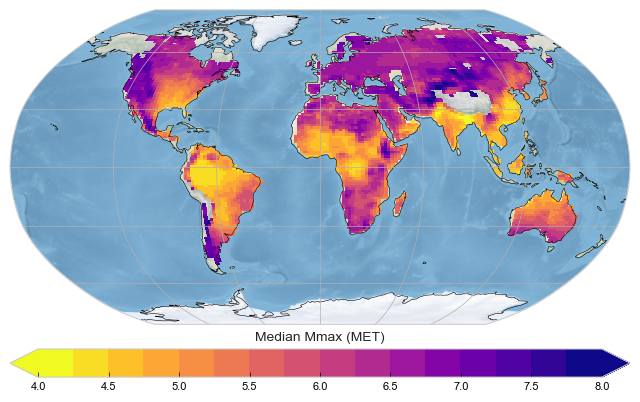

In [73]:
img_extent = (lon_min, lon_max, lat_min, lat_max)
title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = 'Median Mmax (MET)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.arange(4.0, 8.25, 0.25)

cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, mmax50_present, transform = ccrs.PlateCarree(), 
                         cmap = 'plasma_r', norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title(model + " SSP" + ssp + " Contemporary Mmax (" + ta_present_start[0:4] + "-" + 
          ta_present_end[0:4] + ")", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + 
            str(Tair_threshold) + 'Mmax_present.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')   
plt.show(); plt.close()

In [4]:
# longitudes = var_low_res.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
# longitudes = (longitudes + 180) % 360 - 180

# longitudes

## 6.3. Future Mmax

In [ ]:
img_extent = (lon_min, lon_max, lat_min, lat_max)
title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = 'Median Mmax (MET)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.arange(4.0, 8.25, 0.25)

cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, mmax50_future, transform = ccrs.PlateCarree(), 
                         cmap = 'plasma_r', norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title(model + " SSP" + ssp + " Future Mmax (" + ta_present_start[0:4] + "-" + ta_present_end[0:4] + 
          ")", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + str(Tair_threshold) + 
            'Mmax_future.png', dpi = 600, transparent = False, bbox_inches = 'tight')   
plt.show(); plt.close()

## 6.4. Difference between present and future Mmax

In [ ]:
def make_cmap_from_bounds_colors(colores,bounds,name_colorbar):
    import matplotlib.colors as clr
    '''El comando de obtener una colorbar dado posicion de colores y sus colores en una lista de tuplas
     de RGB, En el proceso interno las posiciones de los colores se normalizan de 0 a 1.
     - bounds: la lista de posiciones debe ser un array
     - name_colorbar: es un string'''

    scale_factor =  ((255-0.)/(bounds.max() - bounds.min()))
    new_bounds = list(np.array(np.round((bounds - bounds.min())*scale_factor/255.,3),dtype = float))
    
    nueva_tupla = [((new_bounds[i]),colores[i],) for i in range(len(colores))]
    cmap_nueva = clr.LinearSegmentedColormap.from_list(name_colorbar,nueva_tupla)
    

    return cmap_nueva

In [ ]:
cutpoints = np.array([-1, -0.45, -0.25, 0, 0.3])  # Adjust these values as needed
# Define the colors for the colormap
colors = [(45/255., 21/255., 23/255.), 
          (193/255., 74/255., 84/255.), 
          (235/255., 216/255., 82/255.), 
          (255/255., 255/255., 255/255.),
          (0/255., 60/255., 48/255.)]  # Adjust these colors as needed

cmap_Mmax = make_cmap_from_bounds_colors(colors,cutpoints, 'Mmax_new')
cmap_Mmax.set_under((45/255., 21/255., 23/255.))
cmap_Mmax.set_over((0/255., 60/255., 48/255.))

diff_mmax = mmax50_future - mmax50_present

img_extent = (lon_min, lon_max, lat_min, lat_max)
title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = 'Median Mmax difference ($\Delta$MET)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.linspace(-1,0.3,27)

cmap = cmap_Mmax
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, diff_mmax, transform = ccrs.PlateCarree(), 
                         cmap = cmap_Mmax, norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title(model + " SSP" + ssp + " Difference in Mmax (Future - Present)", fontsize = 12)

# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + 
            str(Tair_threshold) + 'Mmax_difference.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')   
plt.show(); plt.close()

# 7. Multi-model averaging

Holy shit holy shit holy shit holy shit

## 7.1. Import necessary packages

In [1]:
# =============================================================================
# Load packages
# =============================================================================

import HHB as PyHHB
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
from scipy.stats import mannwhitneyu
import datetime
from math import sqrt
from joblib import Parallel, delayed
from global_land_mask import globe

C:\Users\haley\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# =============================================================================
# A quick plot!
# =============================================================================
import pylab as plt 

import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Patch
from matplotlib import rcParams
import cartopy.feature as cfeature

rcParams['legend.frameon'] = False 
rcParams['legend.markerscale'] = 2.
rcParams['legend.fontsize'] = 14.
rcParams['axes.edgecolor'] = '0.8'
rcParams['axes.labelcolor'] = '0.15'
rcParams['axes.linewidth'] = '0.8'
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 17
rcParams[u'text.color'] = u'.15'
rcParams[u'xtick.direction'] = u'in'
rcParams[u'xtick.major.width'] = 0.5
rcParams[u'xtick.labelsize'] = 13
rcParams[u'ytick.labelsize'] = 13
rcParams[u'ytick.color'] = u'.15'
rcParams[u'ytick.direction'] = u'in'
rcParams[ u'font.sans-serif'] = [u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']
rcParams['hatch.linewidth'] = 1

## 7.2. Define `longitude_flip()`

In [2]:
def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.
        
        ** Only works for global data. Do not apply to data with a clipped longitude range **
        
        Parameters
        ----------
        var : Data Array
    """    
    # get var info
    x = var.lon # extract original longitude values
    lon_name = x.name        # store name of longitude coordinate
    nx = len(x)              # longitude resolution
    
    # determine longitude format and create an array of new lons in opposite convention
    if min(x) < 0: 
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons = np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x) > 180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons = np.linspace((min(x)-180), (max(x)-180), nx)
        
    # shift the data by 180° of longitude
    nshift = nx // 2
    var = var.roll({lon_name: nshift}, roll_coords = False)
            
    # update longitude coord with new values
    var = var.assign_coords({lon_name : new_lons})
    
    # add attributes documenting change
    # timestamp = datetime.now().strftime("%B %d, %Y, %r")
    # var.attrs['history'] = f'flipped longitudes {timestamp}'
    # var.attrs['original_lons'] = x.values
    
    return(var)

## 7.3. Load in & pre-process present-day data

In [15]:
workdir = 'C:/Users/haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'
path_data = workdir + 'latest_PyHHB/outputs/DataArrays/'

ssp = '245'
person_condition = 'YNG_Morris_2021'
Tair_threshold = 25

mmax_ACCESS_p = xr.open_dataset(path_data + 'ACCESS-CM2/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold)
                                + '_mmax_p.nc')
mmax_CMCC_p = xr.open_dataset(path_data + 'CMCC-ESM2/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                              '_mmax_p.nc')
# mmax_EC_p = xr.open_dataset(path_data + 'EC-Earth3/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
#                             '_mmax_p.nc')
mmax_GFDL_p = xr.open_dataset(path_data + 'GFDL-ESM4/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                              '_mmax_p.nc')
mmax_MIROC_p = xr.open_dataset(path_data + 'MIROC6/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                               '_mmax_p.nc')
mmax_MPI_p = xr.open_dataset(path_data + 'MPI-ESM1-2-HR/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold)
                             + '_mmax_p.nc')

In [16]:
ref = mmax_ACCESS_p

mmax_CMCC_p_lowres = mmax_CMCC_p.interp_like(ref, method = 'linear')
mmax_GFDL_p_lowres = mmax_GFDL_p.interp_like(ref, method = 'linear')
mmax_MIROC_p_lowres = mmax_MIROC_p.interp_like(ref, method = 'linear')
mmax_MPI_p_lowres = mmax_MPI_p.interp_like(ref, method = 'linear')

In [17]:
all_present = xr.merge([mmax_ACCESS_p.rename({"mmax50_present": "mmax50_ACCESS"}), 
                        mmax_CMCC_p_lowres.rename({"mmax50_present": "mmax50_CMCC"}), 
                        mmax_GFDL_p_lowres.rename({"mmax50_present": "mmax50_GFDL"}),
                        mmax_MIROC_p_lowres.rename({"mmax50_present": "mmax50_MIROC"}),
                        mmax_MPI_p_lowres.rename({"mmax50_present": "mmax50_MPI"})])

In [18]:
all_present2 = all_present

Total = all_present.to_array(dim = 'new1').sum('new1', skipna = True)
all_present = all_present.assign(sumtotal = Total)

Count = all_present2.to_array(dim = 'new2').count('new2')
all_present2 = all_present2.assign(modelcount = Count)

In [19]:
mean = all_present.sumtotal / all_present2.modelcount

In [20]:
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360

latitudes = mean.coords['lat'].sel(lat = slice(lat_min, lat_max)).values # RANGE of latitudes (-89.5,
                                                                            # 89.5, 1 degree)

# long_name:      longitude
# units:          degrees_east
# axis:           X
longitudes = mean.coords['lon'].sel(lon = slice(lon_min, lon_max)).values  # RANGE of longitudes 
                                                                              # (0.625,359.375, 1.25 
                                                                              # degree)
    
(longitudes + 180) % 360 - 180

# longitudes = longitude_flip(longitudes)

for i_lat, lat in enumerate(latitudes):
    for i_lon, lon in enumerate(longitudes):

        if all_present2.modelcount.isel(lat = i_lat, lon = i_lon).values < 3:

            mean[i_lat, i_lon] = np.nan

## 7.4. Quick MD plot of present-day

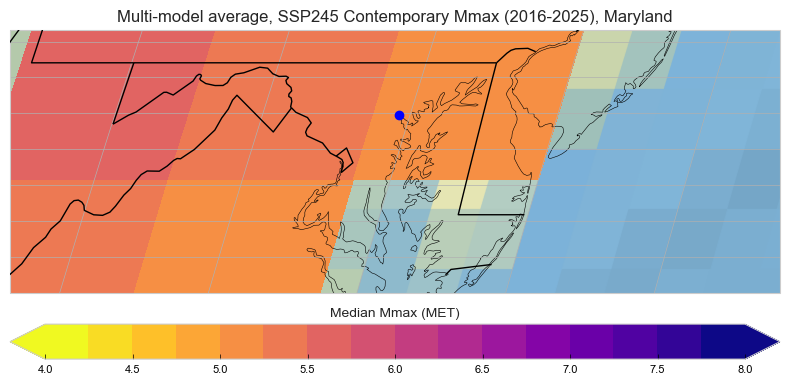

In [34]:
# GLOBE
# lat_min = -60
# lat_max = 75
# lon_min = 0
# lon_max = 360

# MARYLAND
lat_min = 37.8
lat_max = 40
lon_min = 280
lon_max = 287

longitudes = mean.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
longitudes = (longitudes + 180) % 360 - 180
latitudes = mean.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
# title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = 'Median Mmax (MET)'
fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson() , extent = img_extent)
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.arange(4.0, 8.25, 0.25)
cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
# filled_c = ax.pcolormesh(longitudes, latitudes, np.array(mmax_MIROC_p_lowres.mmax50_present.values), 
#                          transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)
filled_c = ax.pcolormesh(longitudes, latitudes, 
                         np.array(mean.sel(lon = slice(lon_min, lon_max)).sel(lat = slice(lat_min, lat_max)).values), 
                         transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)

# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title("Multi-model average, SSP" + ssp + " Contemporary Mmax (2016-2025), Maryland", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

scale = '50m'
states50 = cfeature.NaturalEarthFeature(
            category = 'cultural',
            name = 'admin_1_states_provinces_lines',
            scale = scale,
            facecolor = 'none',
            edgecolor = 'k')
ax.add_feature(states50, zorder = 3)

plt.plot(283.3878, 39.2904,
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

# ax.add_feature(cfeature.OCEAN, zorder = 1)

fig.tight_layout()
plt.savefig(workdir + 'latest_PyHHB/outputs/Figures/avg/present_avg_MD.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')   
plt.show(); plt.close()

## 7.5. Load in & pre-process future data

In [4]:
workdir = 'C:/Users/haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'
path_data = workdir + 'latest_PyHHB/outputs/DataArrays/'

ssp = '245'
person_condition = 'YNG_Morris_2021'
Tair_threshold = 25

mmax_ACCESS_f = xr.open_dataset(path_data + 'ACCESS-CM2/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold)
                                + '_mmax_f.nc')
mmax_CMCC_f = xr.open_dataset(path_data + 'CMCC-ESM2/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                              '_mmax_f.nc')
# mmax_EC_f = xr.open_dataset(path_data + 'EC-Earth3/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
#                             '_mmax_f.nc')
mmax_GFDL_f = xr.open_dataset(path_data + 'GFDL-ESM4/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                              '_mmax_f.nc')
mmax_MIROC_f = xr.open_dataset(path_data + 'MIROC6/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold) +
                               '_mmax_f.nc')
mmax_MPI_f = xr.open_dataset(path_data + 'MPI-ESM1-2-HR/ssp' + ssp + '/' + person_condition + '/tover' + str(Tair_threshold)
                             + '_mmax_f.nc')

C:\Users\haley\.conda\envs\hhb3\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'metpy.io.gini' has no attribute 'GiniXarrayBackend'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
ref = mmax_ACCESS_f

mmax_CMCC_f_lowres = mmax_CMCC_f.interp_like(ref, method = 'linear')
mmax_GFDL_f_lowres = mmax_GFDL_f.interp_like(ref, method = 'linear')
mmax_MIROC_f_lowres = mmax_MIROC_f.interp_like(ref, method = 'linear')
mmax_MPI_f_lowres = mmax_MPI_f.interp_like(ref, method = 'linear')

In [6]:
all_future = xr.merge([mmax_ACCESS_f.rename({"mmax50_future": "mmax50_ACCESS"}), 
                       mmax_CMCC_f_lowres.rename({"mmax50_future": "mmax50_CMCC"}), 
                       mmax_GFDL_f_lowres.rename({"mmax50_future": "mmax50_GFDL"}),
                       mmax_MIROC_f_lowres.rename({"mmax50_future": "mmax50_MIROC"}),
                       mmax_MPI_f_lowres.rename({"mmax50_future": "mmax50_MPI"})])

In [7]:
all_future2 = all_future

Total = all_future.to_array(dim = 'new1').sum('new1', skipna = True)
all_future = all_future.assign(sumtotal = Total)

Count = all_future2.to_array(dim = 'new2').count('new2')
all_future2 = all_future2.assign(modelcount = Count)

In [8]:
mean_future = all_future.sumtotal / all_future2.modelcount

In [9]:
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360

latitudes = mean_future.coords['lat'].sel(lat = slice(lat_min, lat_max)).values # RANGE of latitudes (-89.5,
                                                                            # 89.5, 1 degree)

# long_name:      longitude
# units:          degrees_east
# axis:           X
longitudes = mean_future.coords['lon'].sel(lon = slice(lon_min, lon_max)).values  # RANGE of longitudes 
                                                                              # (0.625,359.375, 1.25 
                                                                              # degree)
    
(longitudes + 180) % 360 - 180

# longitudes = longitude_flip(longitudes)

for i_lat, lat in enumerate(latitudes):
    for i_lon, lon in enumerate(longitudes):

        if all_future2.modelcount.isel(lat = i_lat, lon = i_lon).values < 3:

            mean_future[i_lat, i_lon] = np.nan

## 7.6. Quick MD plot of future

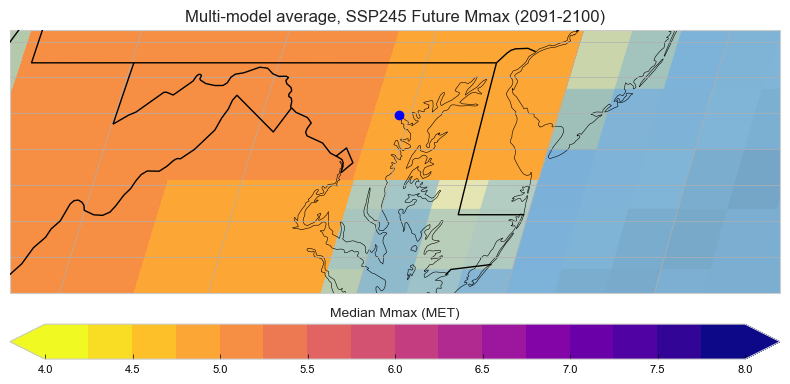

In [11]:
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# GLOBE
# lat_min = -60
# lat_max = 75
# lon_min = 0
# lon_max = 360

# MARYLAND
lat_min = 37.8
lat_max = 40
lon_min = 280
lon_max = 287

longitudes = mean_future.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
longitudes = (longitudes + 180) % 360 - 180
latitudes = mean_future.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
# title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = 'Median Mmax (MET)'
fig = plt.figure(figsize = (8, 8))
# ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # , extent = img_extent)
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(), extent = img_extent)
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.arange(4.0, 8.25, 0.25)
cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
# filled_c = ax.pcolormesh(longitudes, latitudes, np.array(mmax_MIROC_p_lowres.mmax50_future.sel(lat = slice(lat_min, lat_max)).values), 
#                          transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)
filled_c = ax.pcolormesh(longitudes, latitudes, 
                         np.array(mean_future.sel(lon = slice(lon_min, lon_max)).sel(lat = slice(lat_min, lat_max)).values),
                         transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)

# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

scale = '50m'
states50 = cfeature.NaturalEarthFeature(
            category = 'cultural',
            name = 'admin_1_states_provinces_lines',
            scale = scale,
            facecolor = 'none',
            edgecolor = 'k')
ax.add_feature(states50, zorder = 3)

plt.title("Multi-model average, SSP" + ssp + " Future Mmax (2091-2100)", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()

# ax.add_feature(cfeature.OCEAN, zorder = 1)

plt.plot(283.3878, 39.2904,
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )

plt.savefig(workdir + 'latest_PyHHB/outputs/Figures/avg/future_avg_YNG.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')   
plt.show(); plt.close()

# 8. Multi-model average difference plotting

In [18]:
def make_cmap_from_bounds_colors(colores,bounds,name_colorbar):
    import matplotlib.colors as clr
    '''El comando de obtener una colorbar dado posicion de colores y sus colores en una lista de tuplas
     de RGB, En el proceso interno las posiciones de los colores se normalizan de 0 a 1.
     - bounds: la lista de posiciones debe ser un array
     - name_colorbar: es un string'''

    scale_factor =  ((255-0.)/(bounds.max() - bounds.min()))
    new_bounds = list(np.array(np.round((bounds - bounds.min())*scale_factor/255.,3),dtype = float))
    
    nueva_tupla = [((new_bounds[i]),colores[i],) for i in range(len(colores))]
    cmap_nueva = clr.LinearSegmentedColormap.from_list(name_colorbar,nueva_tupla)
    

    return cmap_nueva

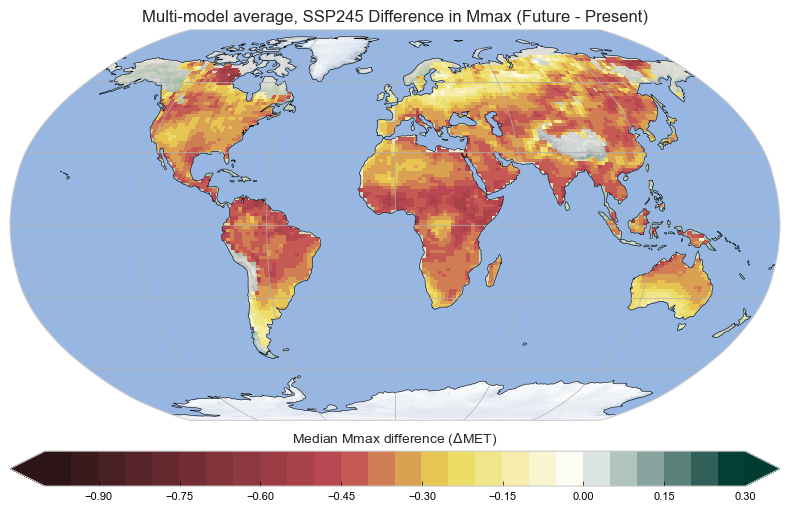

In [19]:
diff = mean_future - mean

lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360
longitudes = diff.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
longitudes = (longitudes + 180) % 360 - 180
latitudes = diff.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

cutpoints = np.array([-1, -0.45, -0.25, 0, 0.3])  # Adjust these values as needed
# Define the colors for the colormap
colors = [(45/255., 21/255., 23/255.), 
          (193/255., 74/255., 84/255.), 
          (235/255., 216/255., 82/255.), 
          (255/255., 255/255., 255/255.),
          (0/255., 60/255., 48/255.)]  # Adjust these colors as needed

cmap_Mmax = make_cmap_from_bounds_colors(colors,cutpoints, 'Mmax_new')
cmap_Mmax.set_under((45/255., 21/255., 23/255.))
cmap_Mmax.set_over((0/255., 60/255., 48/255.))

img_extent = (lon_min, lon_max, lat_min, lat_max)
title_colorbar = 'Median Mmax difference ($\Delta$MET)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.linspace(-1,0.3,27)

cmap = cmap_Mmax
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, diff, transform = ccrs.PlateCarree(), 
                         cmap = cmap_Mmax, norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title("Multi-model average, SSP" + ssp + " Difference in Mmax (Future - Present)", fontsize = 12)

# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)
ax.add_feature(cfeature.OCEAN, zorder = 1)
fig.tight_layout()
plt.savefig(workdir + 'latest_PyHHB/outputs/Figures/avg/diff_avg.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')   

plt.show(); plt.close()

### range test

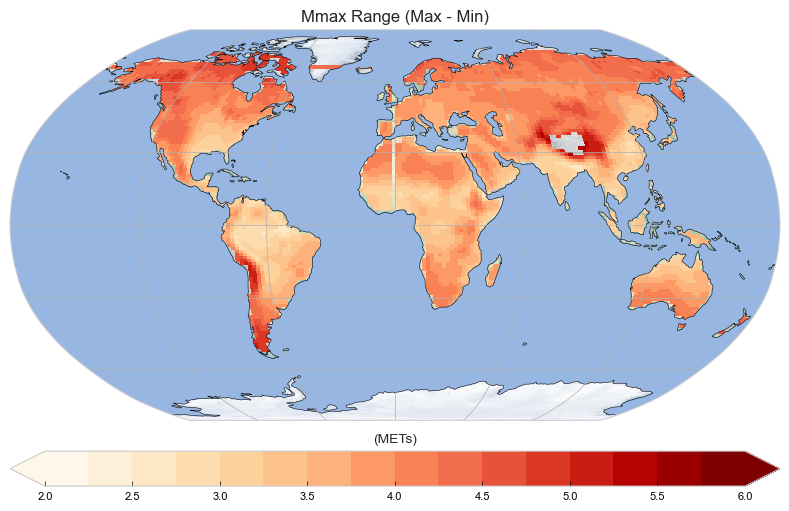

In [48]:
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360
longitudes = data.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
longitudes = (longitudes + 180) % 360 - 180
latitudes = data.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
# title = model + '.ssp' + ssp + '.' + person_condition + '.tover' + str(Tair_threshold)
title_colorbar = '(METs)'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

data = np.array(mmax_MIROC_f_lowres.mmax50_future.values)

data = np.ma.array(data, mask = np.isnan(data))

levels = np.arange(2, 6.25, 0.25)
cmap = plt.get_cmap('plasma_r')

norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, data, 
                         transform = ccrs.PlateCarree(), cmap = 'OrRd', norm = norm)
# filled_c = ax.pcolormesh(longitudes, latitudes, np.array(mean_future.values), 
#                          transform = ccrs.PlateCarree(), cmap = 'plasma_r', norm = norm)

# ax.add_feature(cfeature.OCEAN, zorder = 1)  #zorder > 10

# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

ax.add_feature(cfeature.OCEAN, zorder = 1)

plt.title("Mmax Range (Max - Min)", fontsize = 12)
fig.tight_layout()
plt.savefig(workdir + 'latest_PyHHB/outputs/Figures/avg/range_avg.png', dpi = 600, transparent = False, 
            bbox_inches = 'tight')
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

In [47]:
Max = all_future.to_array(dim = 'new3').max('new3', skipna = True)
Min = all_future.to_array(dim = 'new3').min('new3', skipna = True)
data = Max - Min

# 9. What if we calculated a warming level

## 9.1. Import packages

In [1]:
import xarray as xr
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import dask

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 9.2. Open historical data from model

In [3]:
# Get historical monthly data of model

# =============================================================================
# Defining directories
# =============================================================================
workdir = 'C:/Users/haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'

path_hist_data = workdir + 'CMIP_data/GFDL-ESM4/historical/monthly/'
path_scenar_data = workdir + 'CMIP_data/GFDL-ESM4/monthly/tas/'
path_save_warm_lvl = workdir + 'CMIP_data/GFDL-ESM4/warming_levels/'

In [4]:
# D1 = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/Amon/' + 
#                        'tas/gn/v20191108/tas_Amon_NorESM2-MM_historical_r1i1p1f1_gn_*.nc')

D1 = xr.open_dataset(path_hist_data + 'tas/tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc')

D1

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 780)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/a54fe2f4-0a68-4420-8702-36750bde9b05
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

## 9.3. Open future data from model

In [5]:
# Get monthly data of model from the scenario you're interested in
# D2 = xr.open_mfdataset('/g/data/oi10/replicas/CMIP6/ScenarioMIP/NCC/NorESM2-MM/ssp370/r1i1p1f1/Amon/'
#                        + 'tas/gn/v20191108/tas_Amon_NorESM2-MM_ssp370_r1i1p1f1_gn_*.nc', 
#                        combine = 'nested', concat_dim='time')
D2 = xr.open_dataset(path_scenar_data + 'tas_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc')
D2

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/193372a3-8233-4262-a351-9dfe0b568c21
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

## 9.4. Data preprocessing

In [6]:
# Join them into one xarray
D3 = xr.concat([D1, D2], dim = 'time')
D3

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, time: 1812, lon: 288)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    lat_bnds   (time, lat, bnds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds   (time, lon, bnds) float64 0.0 1.25 1.25 2.5 ... 358.8 358.8 360.0
    tas        (time, lat, lon) float32 236.8 236.7 236.7 ... 247.2 247.2 247.3
    time_bnds  (time, bnds) object 1950-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/a54fe2f4-0a68-4420-8702-36750bde9b05
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

In [7]:
# drop useless variable and convert to celcius
Tas2 = D3['tas'].drop_vars('height')
Tas = Tas2 - 273.15

## 9.5. Calculate global average temperature for historical baseline period

In [8]:
# Calculated the mean global temps, weighted by latitude
weights = np.cos(np.deg2rad(Tas.lat))
weights.name = "weights"
air_weighted = Tas.weighted(weights)
weighted_mean = air_weighted.mean(("lon", "lat"))

In [9]:
%%time
# find the historical temp to compare to. 
mean2 = weighted_mean.sel(time = slice('1950-01-01', '1976-12-31'))
Av = np.nanmean(mean2)
Av

CPU times: total: 0 ns
Wall time: 5.22 ms


13.529542511259033

## 9.5. Determine year of warming level being achieved

In [10]:
%%time

# Do a 20 year rolling annual average global temp
Mean_Y = weighted_mean.resample(time = 'Y').mean()
rolling_mean = Mean_Y.rolling(time = 21, center = True).mean().compute()
rolling_mean

CPU times: total: 15.6 ms
Wall time: 46.5 ms


<xarray.DataArray 'tas' (time: 151)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
       13.52149095, 13.51568123, 13.52363785, 13.53241386, 13.52892511,
       13.51796618, 13.51741689, 13.52561682, 13.52772234, 13.52122588,
       13.50960828, 13.51168346, 13.52136422, 13.51773355, 13.516392  ,
       13.5333372 , 13.55325133, 13.56340147, 13.5671798 , 13.57693477,
       13.60027568, 13.62641301, 13.61990144, 13.60795862, 13.60599328,
       13.60993586, 13.62534623, 13.63729344, 13.64592631, 13.66044484,
       13.68292286, 13.71358563, 13.73361693, 13.74620217, 13.77505182,
       13.80516907, 13.82705226, 13.84369094, 13.86314135, 13.89030616,
       13.907522  , 13.91310614, 13.92707155, 13.97770367, 14.01173655,
       14.03550696, 14.06881082, 14.10616202, 14.14346537, 14.17749194,
       14.19760691, 14.21534466, 14.23627579, 14.26386151, 14.29079509,
       14.31368305, 14.34507511, 14.37628292, 14.40388844, 14.42762925,
       14.4540387 , 14.4802824 , 14.5070204 , 14.51966137, 14.53162458,
       14.56309157, 14.59463951, 14.62039245, 14.63664498, 14.64692766,
       14.65546081, 14.6779542 , 14.69168879, 14.70130176, 14.70855924,
       14.71882584, 14.7335723 , 14.747324  , 14.75936503, 14.78119782,
       14.79867932, 14.81150604, 14.82881921, 14.85373135, 14.8751516 ,
       14.89688348, 14.91948622, 14.94385014, 14.94949831, 14.96736229,
       14.99287572, 15.02354472, 15.04163288, 15.06970696, 15.09681355,
       15.1126422 , 15.13122745, 15.15134651, 15.16894467, 15.1898236 ,
       15.19597252, 15.21065609, 15.23132162, 15.25243469, 15.26078056,
       15.28235237, 15.3037154 , 15.32301862, 15.32940022, 15.35453294,
       15.37357967, 15.37918989, 15.39355967, 15.41719711, 15.42744216,
       15.44288565, 15.47372988, 15.48451899, 15.49820526, 15.51473827,
       15.53105981, 15.54505871, 15.5664854 , 15.57378612, 15.58499148,
       15.60882554, 15.61352226, 15.62289665, 15.62856452, 15.63535196,
       15.6480228 ,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])
Coordinates:
  * time     (time) object 1950-12-31 00:00:00 ... 2100-12-31 00:00:00

In [11]:
#The threshold is the historical temp found above plus what ever warming level you want
warming_level = 1.5
threshold_value = Av + warming_level

# Find the first time step where the value is above the threshold
first_above_threshold = rolling_mean['time'].where(rolling_mean > threshold_value, drop = True).min()

# Print the result
print("First time step above the threshold:", first_above_threshold)

First time step above the threshold: <xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2052, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


## 9.6. Define range of years surrounding warming level

There are two ways of doing this -- Vecellio et al (2023) style, and Seneviratne et al (2020) style. Both are represented here, but I think we'll stick with Seneviratne et al (2020)'s method for now.

### 9.6.1. Vecellio et al (2023) style

In [27]:
# Choose range that you'd like warming level centered around
warm_lvl_range = 0.5

In [38]:
# Calculate years below threshold
yrs_blo_thresh_v = rolling_mean['time'].where(rolling_mean > (threshold_value - warm_lvl_range),
                                                   drop = True)
yrs_blo_thresh_v = yrs_blo_thresh_v['time'].where(yrs_blo_thresh_v['time'] < first_above_threshold,
                                                            drop = True)
lower_bound_v = yrs_blo_thresh_v.min()
yrs_blo_thresh_v_max = yrs_blo_thresh_v.max()

In [39]:
# Calculate years above threshold
yrs_abv_thresh_v = rolling_mean['time'].where(rolling_mean < (threshold_value + warm_lvl_range),
                                                   drop = True)
yrs_abv_thresh_v = yrs_abv_thresh_v['time'].where(yrs_abv_thresh_v['time'] > first_above_threshold,
                                                            drop = True)
yrs_abv_thresh_v_min = yrs_abv_thresh_v.min()
upper_bound_v = yrs_abv_thresh_v.max()
print(yrs_abv_thresh_v_min)
print(yrs_abv_thresh_v_max)

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2053, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)
<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2079, 12, 31, 0, 0, 0, 0, has_year_zero=True),
      dtype=object)


### 9.6.2. Seneviratne et al (2020) style

In [40]:
lower_bound_s = first_above_threshold.values.item().year - 10
upper_bound_s = first_above_threshold.values.item().year + 9

## 9.7. Save results

In [43]:
# Save that shit
warming_level = 1.5
labels = ['1950-1976_avg_temp', 'warming_level', 'threshold_value', 'first_above_threshold', 'lower_bound_v',
         'upper_bound_v', 'lower_bound_s', 'upper_bound_s']
data = [Av, warming_level, threshold_value, first_above_threshold.values.item().year, 
        lower_bound_v.values.item().year, upper_bound_v.values.item().year, lower_bound_s, upper_bound_s]
results = pd.DataFrame(data = data, index = labels, columns = ['value'])
results.to_csv(path_or_buf = path_save_warm_lvl + '1950-1976_' + str(warming_level) + 'warming_lvl.csv')

In [44]:
results

,value
1950-1976_avg_temp,13.529543
warming_level,1.500000
threshold_value,15.029543
first_above_threshold,2052.000000
lower_bound_v,2024.000000
upper_bound_v,2079.000000
lower_bound_s,2042.000000
upper_bound_s,2061.000000


# 10. Bias correction

## 10.1. Import packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from metpy.calc import specific_humidity_from_dewpoint
from metpy.units import units

C:\Users\haley\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 10.2. Load in historical data, scenario data, & warming levels

In [2]:
# Get historical monthly data of model

# =============================================================================
# Defining directories
# =============================================================================
workdir = 'C:/Users/haley/OneDrive/Graduate/Research/epi_physo/PyHHB/PyHHB/'

path_hist_data = workdir + 'CMIP_data/GFDL-ESM4/historical/monthly/'
path_scenar_data = workdir + 'CMIP_data/GFDL-ESM4/monthly/'
path_save_warm_lvl = workdir + 'CMIP_data/GFDL-ESM4/warming_levels/'
path_era5 = workdir + 'ERA5/ERA5/'

In [3]:
hist_cmip_tas = xr.open_dataset(path_hist_data + 'tas/tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc')
hist_cmip_huss = xr.open_dataset(path_hist_data + 
                                 'huss/huss_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc')
hist_cmip_ps = xr.open_dataset(path_hist_data + 'ps/ps_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195001-201412.nc')

C:\Users\haley\.conda\envs\hhb3\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
module 'metpy.io.gini' has no attribute 'GiniXarrayBackend'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# Get monthly data of model from the scenario you're interested in

fut_cmip_tas = xr.open_dataset(path_scenar_data + 'tas/tas_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc')
fut_cmip_huss = xr.open_dataset(path_scenar_data + 'huss/huss_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc')
fut_cmip_ps = xr.open_dataset(path_scenar_data + 'ps/ps_Amon_GFDL-ESM4_ssp245_r1i1p1f1_gr1_201501-210012.nc')

In [5]:
fut_cmip_tas.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    height   float64 ...
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  noleap
    bounds:         time_bnds
    standard_name:  time
    description:    Temporal mean

In [6]:
warming_lvl = pd.read_csv(path_save_warm_lvl + '1950-1976_1.5warming_lvl.csv', index_col = 0)  

## 10.3. Data preprocessing

### 10.3.1. Drop height & convert `tas` to C

In [7]:
hist_cmip_tas['tas']

<xarray.DataArray 'tas' (time: 780, lat: 180, lon: 288)>
[40435200 values with dtype=float32]
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1950-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    standard_name:  air_temperature
    interp_method:  conserve_order2
    original_name:  tas

In [8]:
# drop useless variable and convert to celcius
# hist_cmip_tas = hist_cmip_tas['tas'].drop_vars('height')
hist_cmip_tas = hist_cmip_tas['tas'] - 273.15

# hist_cmip_huss = hist_cmip_huss['huss'].drop_vars('height')

# hist_cmip_ps = hist_cmip_ps['ps'].drop_vars('height')

########################################################

# fut_cmip_tas = fut_cmip_tas['tas'].drop_vars('height')
fut_cmip_tas = fut_cmip_tas['tas'] - 273.15

# fut_cmip_huss = fut_cmip_huss['huss'].drop_vars('height')

# fut_cmip_ps = fut_cmip_ps['ps'].drop_vars('height')

### 10.3.2. Subset historical data around 1950-1976 baseline

Seneviratne et al (2020) uses a baseline around 1850-1900. We instead follow Vecellio et al (2022) in using a baseline around 1950-1976 so as to compare against ERA5 data.

In [9]:
hist_cmip_tas = hist_cmip_tas.sel(time = slice('1950-01-01', '1976-12-31'))
hist_cmip_huss = hist_cmip_huss.sel(time = slice('1950-01-01', '1976-12-31'))
hist_cmip_ps = hist_cmip_ps.sel(time = slice('1950-01-01', '1976-12-31'))

### 10.3.3. Subset scenario data around warming level

When subsetting scenario data, include 10 years before the warming target year and 9 years after the warming target year. This is in line with Seneviratne et al (2020).

Vecellio et al (2022) use a different method, including years within a half-degree centered on the warming target. This, to me, included far too many years to be a useful representation of any particular timeframe in the future, though could be useful in worse emissions scenarios?

In [10]:
lower_bound = int(warming_lvl['value']['lower_bound_s'])
upper_bound = int(warming_lvl['value']['upper_bound_s'])

lower_bound_str = str(lower_bound) + '-01-01'
upper_bound_str = str(upper_bound) + '-12-31'

In [11]:
fut_cmip_tas = fut_cmip_tas.sel(time = slice(lower_bound_str, upper_bound_str))
fut_cmip_huss = fut_cmip_huss.sel(time = slice(lower_bound_str, upper_bound_str))
fut_cmip_ps = fut_cmip_ps.sel(time = slice(lower_bound_str, upper_bound_str))

## 10.4. Averaging data subsets

### 10.4.1. Average historical data subset during baseline period

This includes `tas`, `huss`, and `ps`.

Should this be done using 3hrly data, or monthly data? Presently unclear.

In [12]:
hist_cmip_tas_mean = hist_cmip_tas.mean(dim = 'time', skipna = True, keep_attrs = True)
hist_cmip_huss_mean = hist_cmip_huss.mean(dim = 'time', skipna = True, keep_attrs = True)
hist_cmip_ps_mean = hist_cmip_ps.mean(dim = 'time', skipna = True, keep_attrs = True)

### 10.4.2. Average future data subset during warming level period

Take the average of `tas`, `huss`, and `ps` during the twenty-year period centered around the warming level you care about.

Should this be done using 3hrly or monthly data?

In [13]:
fut_cmip_tas_mean = fut_cmip_tas.mean(dim = 'time', skipna = True, keep_attrs = True)
fut_cmip_huss_mean = fut_cmip_huss.mean(dim = 'time', skipna = True, keep_attrs = True)
fut_cmip_ps_mean = fut_cmip_ps.mean(dim = 'time', skipna = True, keep_attrs = True)

## 10.5. Calculate deltas

Subtract `future - baseline` data to calculate the change in `tas`, `huss`, and `ps`.

In [14]:
tas_cmip_delta = fut_cmip_tas_mean - hist_cmip_tas_mean
huss_cmip_delta = fut_cmip_huss_mean - hist_cmip_huss_mean
ps_cmip_delta = fut_cmip_ps_mean - hist_cmip_ps_mean

In [72]:
# We can also create a different delta for every lat-lon point if we don't average across the entire dataset . . .
hist_cmip_tas


<xarray.DataArray 'tas' (time: 324, lat: 180, lon: 288)>
array([[[-36.378967, -36.402588, -36.426193, ..., -36.308136,
         -36.331757, -36.355362],
        [-35.075104, -35.129913, -35.18486 , ..., -34.911346,
         -34.96582 , -35.0204  ],
        [-33.495377, -33.57776 , -33.660263, ..., -33.24901 ,
         -33.330994, -33.413116],
        ...,
        [-26.848312, -26.81845 , -26.788712, ..., -26.938583,
         -26.908371, -26.87828 ],
        [-26.978775, -26.962723, -26.94667 , ..., -27.027115,
         -27.010986, -26.994873],
        [-26.863693, -26.85756 , -26.85144 , ..., -26.88205 ,
         -26.87593 , -26.869812]],

       [[-42.592407, -42.624527, -42.656662, ..., -42.496017,
         -42.528137, -42.560272],
        [-40.8898  , -40.93567 , -40.981857, ..., -40.754074,
         -40.79901 , -40.844254],
        [-38.926437, -38.990173, -39.05414 , ..., -38.736725,
         -38.79973 , -38.86296 ],
...
        [-23.917557, -23.840912, -23.76419 , ..., -24.147186,
         -24.070694, -23.994156],
        [-23.644165, -23.596298, -23.548553, ..., -23.788391,
         -23.74022 , -23.692139],
        [-23.627457, -23.614166, -23.600891, ..., -23.667313,
         -23.654022, -23.640732]],

       [[-33.53189 , -33.553925, -33.57596 , ..., -33.465775,
         -33.48781 , -33.509857],
        [-32.20543 , -32.25714 , -32.30896 , ..., -32.050842,
         -32.10228 , -32.15381 ],
        [-31.134521, -31.209412, -31.284363, ..., -30.910187,
         -30.98491 , -31.059692],
        ...,
        [-32.155304, -32.139572, -32.12387 , ..., -32.2025  ,
         -32.186752, -32.17102 ],
        [-33.277756, -33.27014 , -33.26271 , ..., -33.30162 ,
         -33.293503, -33.285553],
        [-34.464066, -34.465622, -34.46718 , ..., -34.459366,
         -34.460938, -34.462494]]], dtype=float32)
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1950-01-16 12:00:00 ... 1976-12-16 12:00:00

## 10.6. Load in ERA5 data

In [15]:
era5 = xr.open_dataset(path_era5 + 'data.nc')

## 10.7. Calculate specific humidity from dewpoint and pressure

In [16]:
era5['huss'] = specific_humidity_from_dewpoint(era5['sp'] * units.Pa, era5['t2m'] * units.degK)

## 10.8. Calculate Mmax using PyHHB

In [39]:
era5['t2m_C'] = era5['t2m'] - 273.15

In [42]:
# era5['Mmax'] = SurvLivFull(era5['t2m_C'], era5['huss'], 'q', Mmax_only = True)

## 10.9. Calculate baseline average of ERA5 data

Calculate averages for `tas`, `huss`, and `ps` for the baseline period (1950-1976).

In [17]:
era5_tas = era5['t2m']

In [18]:
era5_tas_mean = era5_tas.mean(dim = 'time', skipna = True, keep_attrs = True)

In [19]:
era5_tas_mean = era5_tas_mean - 273.15

### 10.9.1. Let's try a quick plot . . .

In [23]:
# =============================================================================
# A quick plot!
# =============================================================================
import pylab as plt 

import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from matplotlib.patches import Patch
from matplotlib import rcParams

rcParams['legend.frameon'] = False 
rcParams['legend.markerscale'] = 2.
rcParams['legend.fontsize'] = 14.
rcParams['axes.edgecolor'] = '0.8'
rcParams['axes.labelcolor'] = '0.15'
rcParams['axes.linewidth'] = '0.8'
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 17
rcParams[u'text.color'] = u'.15'
rcParams[u'xtick.direction'] = u'in'
rcParams[u'xtick.major.width'] = 0.5
rcParams[u'xtick.labelsize'] = 13
rcParams[u'ytick.labelsize'] = 13
rcParams[u'ytick.color'] = u'.15'
rcParams[u'ytick.direction'] = u'in'
rcParams[ u'font.sans-serif'] = [u'Arial',
                               u'Liberation Sans',
                               u'Bitstream Vera Sans',
                               u'sans-serif']
rcParams['hatch.linewidth'] = 1

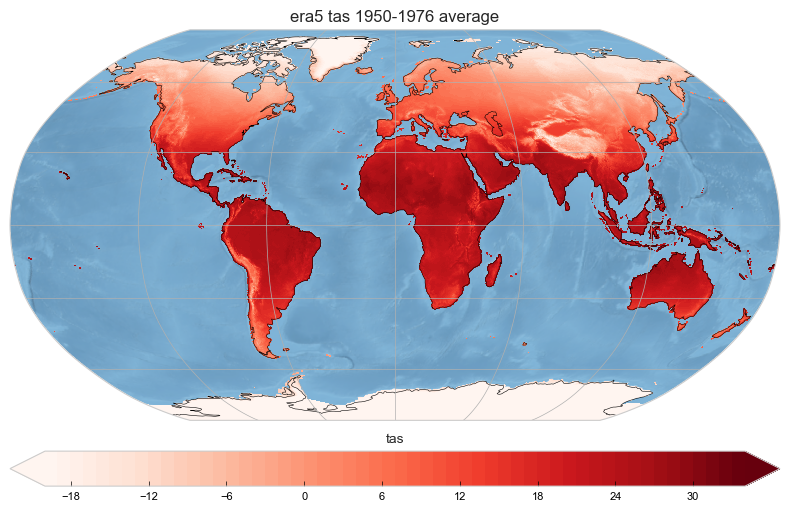

In [69]:
# Setting geography boundaries 
lat_min = 90
lat_max = -90
lon_min = 0
lon_max = 360

longitudes = era5_tas_mean.coords['longitude'].sel(longitude = slice(lon_min, lon_max)).values
latitudes = era5_tas_mean.coords['latitude'].sel(latitude = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
title = 'era5 baseline tas'
title_colorbar = 'tas'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

# levels = np.arange(float(era5_tas_mean.min().values), float(era5_tas_mean.max().values), 1)
levels = np.arange(-20, 35, 1)

# levels = np.arange(float(tas_cmip_delta_interp.min().values), float(tas_cmip_delta_interp.max().values), 1)

cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, era5_tas_mean, transform = ccrs.PlateCarree(), 
                         cmap = 'Reds', norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title("era5 tas 1950-1976 average", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
# plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + 
#             str(Tair_threshold) + 'Mmax_present.png', dpi = 600, transparent = False, 
#             bbox_inches = 'tight')   
plt.show(); plt.close()

## 10.10. Bilinear interpolation of CMIP deltas

### 10.10.1. Do the interpolation

In [20]:
tas_cmip_delta_interp = tas_cmip_delta.interp(lat = era5_tas_mean.latitude, lon = era5_tas_mean.longitude)

### 10.10.2. Make a quick plot

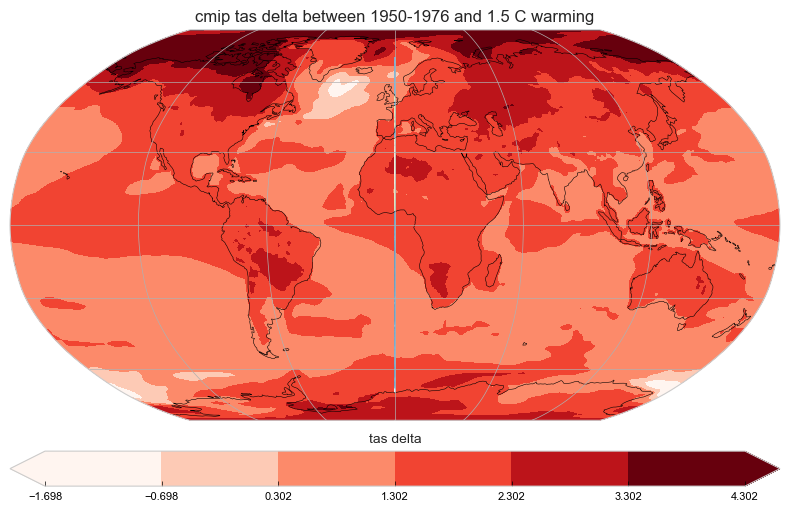

In [67]:
# Setting geography boundaries 
lat_min = 90
lat_max = -90
lon_min = 0
lon_max = 360

longitudes = era5_tas_mean.coords['longitude'].sel(longitude = slice(lon_min, lon_max)).values
latitudes = era5_tas_mean.coords['latitude'].sel(latitude = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
title = 'era5 baseline tas'
title_colorbar = 'tas delta'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

levels = np.arange(float(tas_cmip_delta_interp.min().values), float(tas_cmip_delta_interp.max().values), 1)

cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, tas_cmip_delta_interp, transform = ccrs.PlateCarree(), 
                         cmap = 'Reds', norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title("cmip tas delta between 1950-1976 and 1.5 C warming", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
# plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + 
#             str(Tair_threshold) + 'Mmax_present.png', dpi = 600, transparent = False, 
#             bbox_inches = 'tight')   
plt.show(); plt.close()

## 10.11. Apply CMIP deltas to ERA5 baseline

Add results from 10.8. to the results of 10.7.

### 10.11.1. Apply the delta

In [21]:
baseline_plus_delta = tas_cmip_delta_interp + era5_tas_mean

### 10.11.2. Make a plot

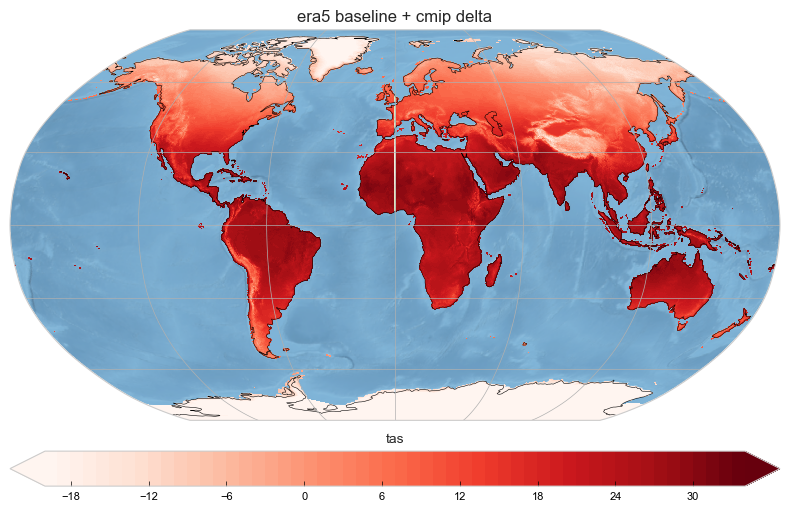

In [73]:
# Setting geography boundaries 
lat_min = 90
lat_max = -90
lon_min = 0
lon_max = 360

longitudes = era5_tas_mean.coords['longitude'].sel(longitude = slice(lon_min, lon_max)).values
latitudes = era5_tas_mean.coords['latitude'].sel(latitude = slice(lat_min, lat_max)).values

img_extent = (lon_min, lon_max, lat_min, lat_max)
title = 'era5 baseline tas'
title_colorbar = 'tas'
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson()) # ,extent=img_extent
ax.stock_img()
ax.coastlines(lw = 0.4)

# levels = np.arange(float(era5_tas_mean.min().values), float(era5_tas_mean.max().values), 1)
levels = np.arange(-20, 35, 1)

# levels = np.arange(float(tas_cmip_delta_interp.min().values), float(tas_cmip_delta_interp.max().values), 1)

cmap = plt.get_cmap('plasma_r')
norm = BoundaryNorm(levels, ncolors = cmap.N, clip = True)
filled_c = ax.pcolormesh(longitudes, latitudes, baseline_plus_delta, transform = ccrs.PlateCarree(), 
                         cmap = 'Reds', norm = norm)
# ax.contourf(longitudes, latitudes, significance, levels = [-0.01, 0.5, 1.0],
#             hatches = ["", 5 * "."], alpha = 0, transform = ccrs.PlateCarree(), lw = 0.5)
  
clb = plt.colorbar(filled_c, orientation = 'horizontal', extend = 'both', pad = 0.04) # ,cax = ax)
clb.ax.tick_params(labelsize = 8) 
clb.ax.set_title(title_colorbar, fontsize = 10)

gl = ax.gridlines(draw_labels = False, linewidth = 0.5)
gl.top_labels = False; gl.left_labels = False

plt.title("era5 baseline + cmip delta", fontsize = 12)
# legend_elements = [Patch(facecolor = (0, 0, 0, 0), edgecolor = 'k', hatch = '...', 
#                          label = 'Statistically significant p < 0.05')]
# plt.legend(handles = legend_elements, bbox_to_anchor = (0.85, -0.1), fontsize = 10, ncol = 1)

fig.tight_layout()
# plt.savefig(path_save + model + '/ssp' + ssp + '/' + person_condition + '/threshold-' + 
#             str(Tair_threshold) + 'Mmax_present.png', dpi = 600, transparent = False, 
#             bbox_inches = 'tight')   
plt.show(); plt.close()

## 10.12. Delta over time at a particular lat-lon

- make a plot of some particular lat-lon points and map the deltas over the course of the calendar year, where each timestep is an average of the 26 years of datapoints in the baseline period
- construct delta easily with xr.groupby
- make sure we're ignoring leap days or whatever

In [46]:
# tas_cmip_delta_interp
# era5['t2m_C']

In [48]:
era5['delta'] = tas_cmip_delta_interp

In [54]:
test = era5.groupby("latitude")[33.0].groupby("longitude")[117]

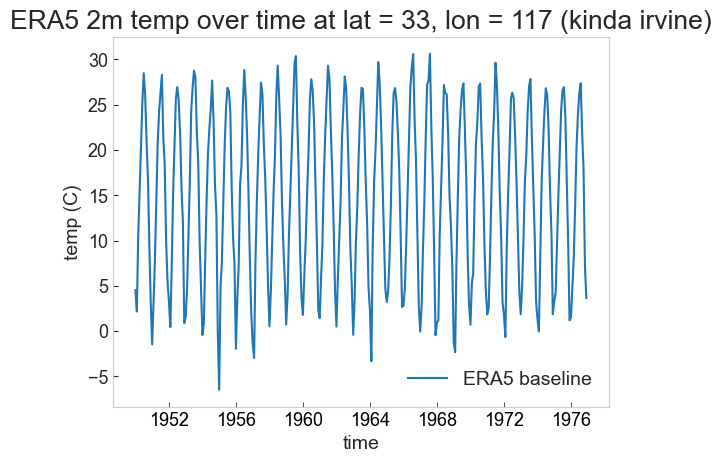

In [61]:
plt.plot(test['time'], test['t2m_C'], label = 'ERA5 baseline')
plt.title('ERA5 2m temp over time at lat = 33, lon = 117 (kinda irvine)')
plt.ylabel('temp (C)')
plt.xlabel('time')
plt.legend()

## 10.13. Save!

# 11. Drafting some words

- no preference on Rs really
- make sure both historical and future scenarios use the same p
- strive to use f1 and make a special note if you do use f2

# 12. Random bullshit

playground lol

In [7]:
mmax_CMCC_p_lowres = mmax_CMCC_p_lowres.roll(lon = nroll)

In [3]:
print('ACCESS dims: ' + str(mmax_ACCESS_p.dims))
print('ACCESS lon: ' + str(mmax_ACCESS_p.lon[-1].values))
print('CMCC dims: ' + str(mmax_CMCC_p.dims))
print('CMCC lon: ' + str(mmax_CMCC_p.lon[-1].values))
print('GFDL dims: ' + str(mmax_GFDL_p.dims))
print('GFDL lon: ' + str(mmax_GFDL_p.lon[-1].values))
print('MIROC dims: ' + str(mmax_MIROC_p.dims))
print('MIROC lon: ' + str(mmax_MIROC_p.lon[-1].values))
print('MPI dims: ' + str(mmax_MPI_p.dims))
print('MPI lon: ' + str(mmax_MPI_p.lon[-1].values))

ACCESS dims: Frozen({'lat': 108, 'lon': 192})
ACCESS lon: 359.0625
CMCC dims: Frozen({'lat': 144, 'lon': 288})
CMCC lon: 358.75
GFDL dims: Frozen({'lat': 135, 'lon': 288})
GFDL lon: 359.375
MIROC dims: Frozen({'lat': 97, 'lon': 256})
MIROC lon: 358.59375
MPI dims: Frozen({'lat': 144, 'lon': 384})
MPI lon: 359.0625


#### Dervla's code

In [3]:
def longitude_flip(var):
    """ Convert longitude values from the -180:180 to 0:360 convention or vice versa.
        
        ** Only works for global data. Do not apply to data with a clipped longitude range **
        
        Parameters
        ----------
        var : Data Array
    """    
    # get var info
    x = var.lon # extract original longitude values
    lon_name = x.name        # store name of longitude coordinate
    nx = len(x)              # longitude resolution
    
    # determine longitude format and create an array of new lons in opposite convention
    if min(x) < 0: 
        # if there are negative values, data is -180:180 and need to switch to 0:360
        new_lons = np.linspace((min(x)+180), (max(x)+180), nx)
    elif max(x) > 180:
        # if the max value is >180, data is in 0:360 format and need to switch to -180:180
        new_lons = np.linspace((min(x)-180), (max(x)-180), nx)
        
    # shift the data by 180° of longitude
    nshift = nx // 2
    var = var.roll({lon_name: nshift}, roll_coords = False)
            
    # update longitude coord with new values
    var = var.assign_coords({lon_name : new_lons})
    
    # add attributes documenting change
    # timestamp = datetime.now().strftime("%B %d, %Y, %r")
    # var.attrs['history'] = f'flipped longitudes {timestamp}'
    # var.attrs['original_lons'] = x.values
    
    return(var)

def match_lat_lon_names(ds):
    for lat_name in ['y', 'latitude', 'nav_lat']:
        if (lat_name in ds.coords) and ('lat' not in ds.coords):
            ds = ds.rename({lat_name: 'lat'})
        else:
            ds = ds
    for lon_name in ['x', 'longitude', 'nav_lon']:
        if (lon_name in ds.coords) and ('lon' not in ds.coords):
            ds = ds.rename({lon_name: 'lon'})
        else:
            ds = ds
    return ds

In [4]:
models = [mmax_CMCC_p, mmax_GFDL_p, mmax_MPI_p]

# import reference grid
# dpath0 = '/Users/dervlamk/OneDrive/research/topo_biases/topo_files'
ref = mmax_ACCESS_p
ref_lat = ref.lat
ref_lon = ref.lon

# define var
var = mmax_CMCC_p

In [5]:
# switch lons from 0:360 to -180:180
var = longitude_flip(var)

In [7]:
var

<xarray.Dataset>
Dimensions:         (lat: 144, lon: 288)
Coordinates:
  * lat             (lat) float64 -59.84 -58.9 -57.96 ... 73.04 73.98 74.92
  * lon             (lon) float64 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
Data variables:
    mmax50_present  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [6]:
# regrid
nx = len(var.lon)
nroll = int(nx / 2) # number of grid cells to shift dataset to get an 180° offset
mmax_CMCC_p_lowres = var.interp_like(ref, method = 'linear')

In [6]:
mmax_CMCC_p_lowres

<xarray.Dataset>
Dimensions:         (lat: 108, lon: 192)
Coordinates:
  * lat             (lat) float64 -59.38 -58.12 -56.88 ... 71.88 73.12 74.38
  * lon             (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Data variables:
    mmax50_present  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [5]:
# # define var
# var = mmax_EC_p
# # switch lons from 0:360 to -180:180
# var = longitude_flip(var)
# # regrid
# nx = len(var.lon)
# nroll = int(nx / 2) # number of grid cells to shift dataset to get an 180° offset
# mmax_EC_p_lowres = var.roll(lon = nroll).interp_like(ref, method = 'linear')

# define var
var = mmax_GFDL_p
# switch lons from 0:360 to -180:180
var = longitude_flip(var)
# regrid
nx = len(var.lon)
nroll = int(nx / 2) # number of grid cells to shift dataset to get an 180° offset
mmax_GFDL_p_lowres = var.roll(lon = nroll).interp_like(ref, method = 'linear')

# define var
var = mmax_MPI_p
# switch lons from 0:360 to -180:180
var = longitude_flip(var)
# regrid
nx = len(var.lon)
nroll = int(nx / 2) # number of grid cells to shift dataset to get an 180° offset
mmax_MPI_p_lowres = var.roll(lon = nroll).interp_like(ref, method = 'linear')

In [6]:
all_data = xr.merge([mmax_ACCESS_p.rename({"mmax50_present": "mmax50_ACCESS"}), 
                     mmax_CMCC_p_lowres.rename({"mmax50_present": "mmax50_CMCC"}), 
                     mmax_GFDL_p_lowres.rename({"mmax50_present": "mmax50_GFDL"}),
                     mmax_MPI_p_lowres.rename({"mmax50_present": "mmax50_MPI"})])
all_data.sel(lat = 30.625, lon = 105.9375, method = 'nearest')

<xarray.Dataset>
Dimensions:        ()
Coordinates:
    lat            float64 30.62
    lon            float64 105.9
Data variables:
    mmax50_ACCESS  float64 ...
    mmax50_CMCC    float64 nan
    mmax50_GFDL    float64 nan
    mmax50_MPI     float64 nan

In [ ]:
# Setting geography boundaries 
lat_min = -60
lat_max = 75
lon_min = 0
lon_max = 360

longitudes = mmax_ACCESS_p.coords['lon'].sel(lon = slice(lon_min, lon_max)).values
latitudes = mmax_ACCESS_p.coords['lat'].sel(lat = slice(lat_min, lat_max)).values

path_data = workdir + 'CMIP_data/'
model = 'ACCESS-CM2'
ripf = 'r1i1p1f1'
grid = 'gn'
land_cover = xr.open_dataset(path_data + model + "/sftlf/sftlf_fx_" + model + "_ssp" + ssp + "_" + ripf + "_" + grid + 
                             ".nc")

for i_lat, lat in enumerate(latitudes):
    for i_lon, lon in enumerate(longitudes):
        
        # Detecting if the pixel selected is over continent (land) or ocean.
        # Here, if more than 45% of the grid cell is land, it is considered land.
        # This analysis could perhaps be moved out of the loop for clarity, and we could instead iterate 
        # only over lat-lon combos that are known to be land.
        
        continent = (land_cover['sftlf'].sel(lat = lat, lon = lon, method = 'nearest') > 45).values
        
        # The above line of code generates a boolean. If it's false, we don't continue with analysis for
        # that grid cell.
        
        if not continent:
            
            continue
            
        all_present_gc = all_data.sel(lat = lat, lon = lon, method = 'nearest')
        
        print

In [50]:
all_data.mean(dim = 'lat',skipna = True)

<xarray.Dataset>
Dimensions:        ()
Data variables:
    mmax50_ACCESS  float64 6.198
    mmax50_CMCC    float64 5.801
    mmax50_GFDL    float64 5.767
    mmax50_MPI     float64 5.95

In [22]:
# mmax_mean_p = (mmax_ACCESS_p.mmax50_present + 
#                mmax_CMCC_p_lowres.mmax50_present + 
#                mmax_GFDL_p_lowres.mmax50_present + 
#                mmax_MPI_p_lowres.mmax50_present) / 4